# GEM analyses and figures from Fink, Alexander, and Janata (20xx)

This notebook steps through all statistical analyses and figures presented in Fink, Alexander, and Janata (20xx). The analyses rely on two data tables that have also been released with this repository (in the data folder). As long as file paths to those .csv files are set accordingly, all analyses should run in Jupyter on anyone's machine. 

#### Prepared by Lauren Fink
For questions: email lkfink@ucdavis.edu  
For issues: submit an issue on the [GEM GitHub page](https://github.com/janatalab/GEM)

In [148]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Load required packages
import os
import sys
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import *
import re
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import pingouin as pg
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') 

# Load data tables (provided with repo)

Please be sure to set the file paths to these tables appropriately.

Note that tapping data are in raw milliseconds. 
For the 1 player data, ratings data are in the table raw and as zscores within participant and item.
For the group data, all ratings have already been z-scored within participant and scale before averaging across group members. 

Experiment IDs are as in the paper:

| Experiment ID | Experiment description|
|:------        |:------|
|1 |            1 player, hear metronome|
|2 |            1 player, hear metronome + self|
|3 |            4 player, hear metronome|
|4 |            4 player, hear metronome + self|
|5 |            4 player, hear metronome + everyone|




In [249]:
# Load data
# USER TODO: set file paths appropriately
op_fpath = '/Users/lauren.fink/Documents/Projects/GEM/Data/one_all.csv' # one player data table
op = pd.read_csv(op_fpath) 
fp_fpath = '/Users/lauren.fink/Documents/Projects/GEM/Data/four_all.csv' # four player data table
fp = pd.read_csv(fp_fpath) 

# Load all functions we will need for future analyses

In [150]:
# Functions used throughout this notebook

# --------------------------------------------------------------------------------------------------------------#
# Basic function to normalize data within a pandas series

# Input:
# - pandas series containing raw data
# Output:
# - pandas series containing normalized data

def zscore(series):
    return (series - series.mean()) / series.std()

# --------------------------------------------------------------------------------------------------------------#
# Function to calculate repeated measures ANOVA from input variables of interest

# Input:
# - Dataframe containing all experiment data
# - Flag whether this data is from group experiment (1) or not (0)
# - Variable of interest to average over (e.g. 'avg_std_async'). Make sure this matches the column label in the data frame
# - Flag whether to zscore data (1) or not (0) in var column of interest. Note that ratings have already been zscored 
#     within each participant and item. Tapping data have not been zscored, as raw values are also of interest.

# Output:
# - table containing AOV results
# - table containing post-hoc tests

def rmaov_results(df, group, var, to_zscore):    
    if group:
        col_label = 'group_num'
    else:
        col_label = 'subID'
        
    # z-score variable of interest, if user requested
    if to_zscore:
        zscores = df.groupby(col_label)[var].transform(zscore)
        df.insert(0, "zscores", zscores, True) 
        var = 'zscores'
    
    means = df.groupby([col_label, 'alpha'], as_index=False)[var].mean()
    print('\n\n')

    # Compute the repeated measures ANOVA
    print('ANOVA table\n')
    print(pg.rm_anova(dv=var, within='alpha', subject=col_label, data=means, detailed=True))
                    
    # Post-hoc tests between all means
    print('\n\nPost-hoc comparisons between all means\n')
    return pg.pairwise_ttests(dv=var, within='alpha', subject=col_label, data=means, alpha = .05, tail = 'one-sided', padjust = 'holm', effsize = 'cohen')


# --------------------------------------------------------------------------------------------------------------#
# Function to return means and sems for any variable of interest against alpha condition (for a single participant or group)

# Input:
# - Dataframe containing all experiment data
# - Flag whether this data is from group experiment (1) or not (0)
# - Variable of interest to average over (e.g. 'avg_std_async'). Make sure this matches the column label in the data frame
# - Flag whether to zscore data (1) or not (0) in var column of interest. Note that ratings have already been zscored 
#     within each participant and item. Tapping data have not been zscored, as raw values are also of interest.

# Output:
# - data frame containing means and sems for variable of interest, in each alpha condition

def return_mean_sem(df, group, var, to_zscore):
    if group:
        col_label = 'group_num'
    else:
        col_label = 'subID'
        
    # z-score variable of interest, if user requested
    if to_zscore:
        zscores = df.groupby(col_label)[var].transform(zscore)
        df.insert(0, "zscores", zscores, True) 
        var = 'zscores'

    # get mean for each sub/group and alpha condition            
    means = df.groupby([col_label, 'alpha'], as_index=False)[var].mean()

    # get mean across groups for each alpha condition
    means_all = means.groupby(['alpha'])[var].mean()
    
    # do the same for the standared error of the mean
    sems = df.groupby([col_label, 'alpha'], as_index=True)[var].sem().reset_index()
    sems_all = means.groupby(['alpha'])[var].sem() 
    
    # subtract baseline mean from each condition mean
    subtract_base = means_all - means_all[0] 
    
    # return means and sems for user
    final_avg_sem_by_cond =  pd.concat([means_all, sems_all, subtract_base], join = "inner", axis = 1)
    final_avg_sem_by_cond.columns = ['mean', 'sem', 'mean-baseline']
    return final_avg_sem_by_cond

    
# --------------------------------------------------------------------------------------------------------------#
# Function to plot any variable of interest against alpha condition for each participant or group in the experiment
# Input:
# - experiment data frame
# - flag whether it is a group exp or not
# - specify the variable of interest to plot (e.g. std async, groove rating, etc.)

# Output:
# - Figure containing multiple subplots (one for each participant or group)
    
    
def plot_all(df, group, varcol): #, to_zscore)

    fig = plt.figure(figsize=(20,20))

    if group: # group tapping
        IDcol = 'group_num'
        group = 1
    else:   
        group = 0
        IDcol = 'subID'
    
    # Calculate means and sems
    means = df.groupby([IDcol, 'alpha'], as_index=False)[varcol].mean()
    sems = df.groupby([IDcol, 'alpha'], as_index=True)[varcol].sem().reset_index()

    # Figure out number of subplots we need in figure
    groups = unique(df[IDcol])
    plotrows = ceil(round(len(groups))/5)
    plotcols = ceil(round(len(groups))/plotrows)

    # Loop through each participant or group and plot 
    for idx, val in enumerate(groups):

        # Subset data
        submeans = means.loc[means[IDcol] == groups[idx]]
        #print(submeans)
        subsems = sems.loc[sems[IDcol] == groups[idx]]
    
        # Create new axis for every subplot
        axstr = str('ax' + str(idx))
        axstr = fig.add_subplot(plotrows, plotcols, idx+1)
        plt.errorbar(submeans['alpha'], submeans[varcol], yerr = subsems[varcol], fmt='-ko')
        axstr.set_xticks(submeans['alpha'])
        axstr.set_xticklabels(submeans['alpha'])
        plt.title(val)
    
    # Add meta-labels to figure
    fig.text(0.5, 0.00, 'Adaptivity', ha='center', va='center', fontsize=16)
    fig.text(0.0, 0.5, varcol, ha='center', va='center', rotation='vertical', fontsize=16)
    fig.tight_layout(h_pad=3, w_pad=3)

# For each experiment, plot every participant's or group's tapping data
Before looking at overall averages, it's important to look at individual participant/group data to make sure that the trends we see on average aren't being driven by a few groups. 


Tapping data for each participant in Experiment 1: 




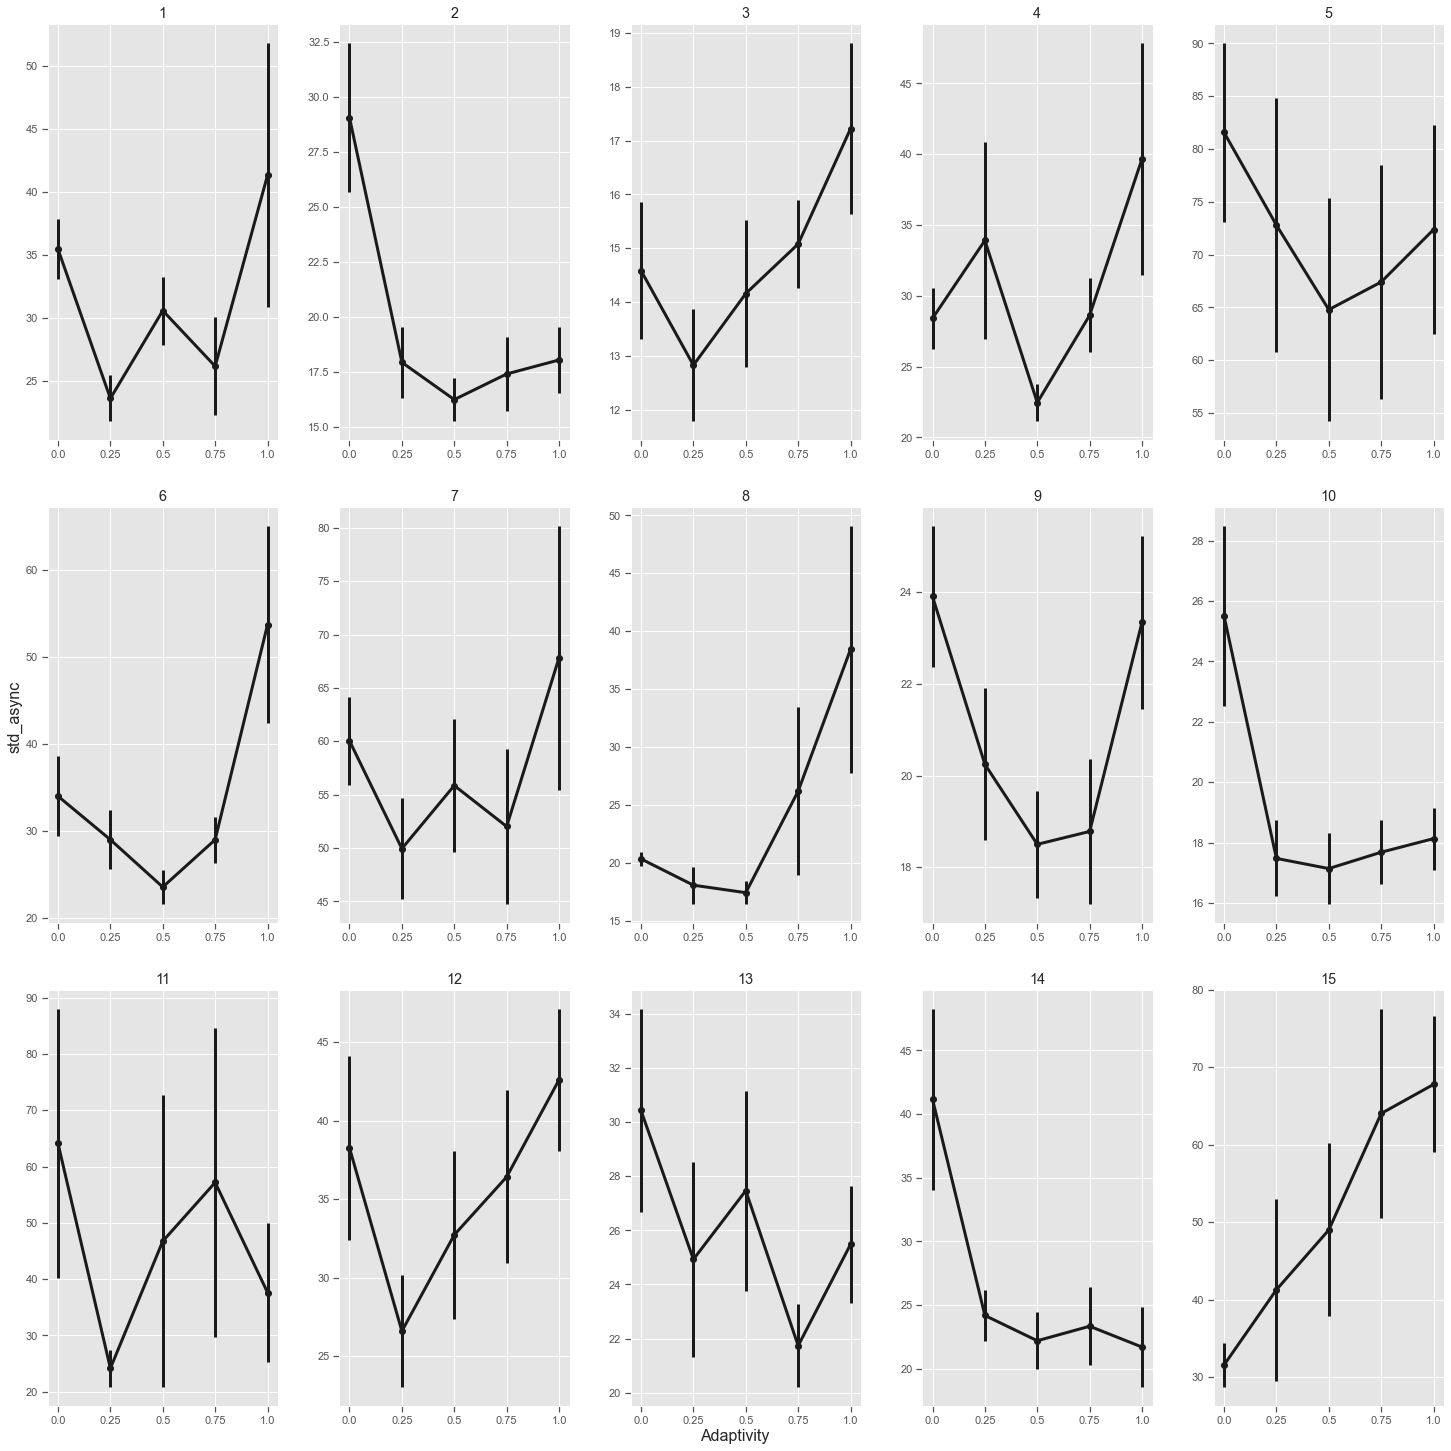

In [151]:
print('\nTapping data for each participant in Experiment 1: \n\n')
df = op.loc[op['expID'] == 1]
plot_all(df, 0, 'std_async')


Tapping data for each participant in Experiment 2: 




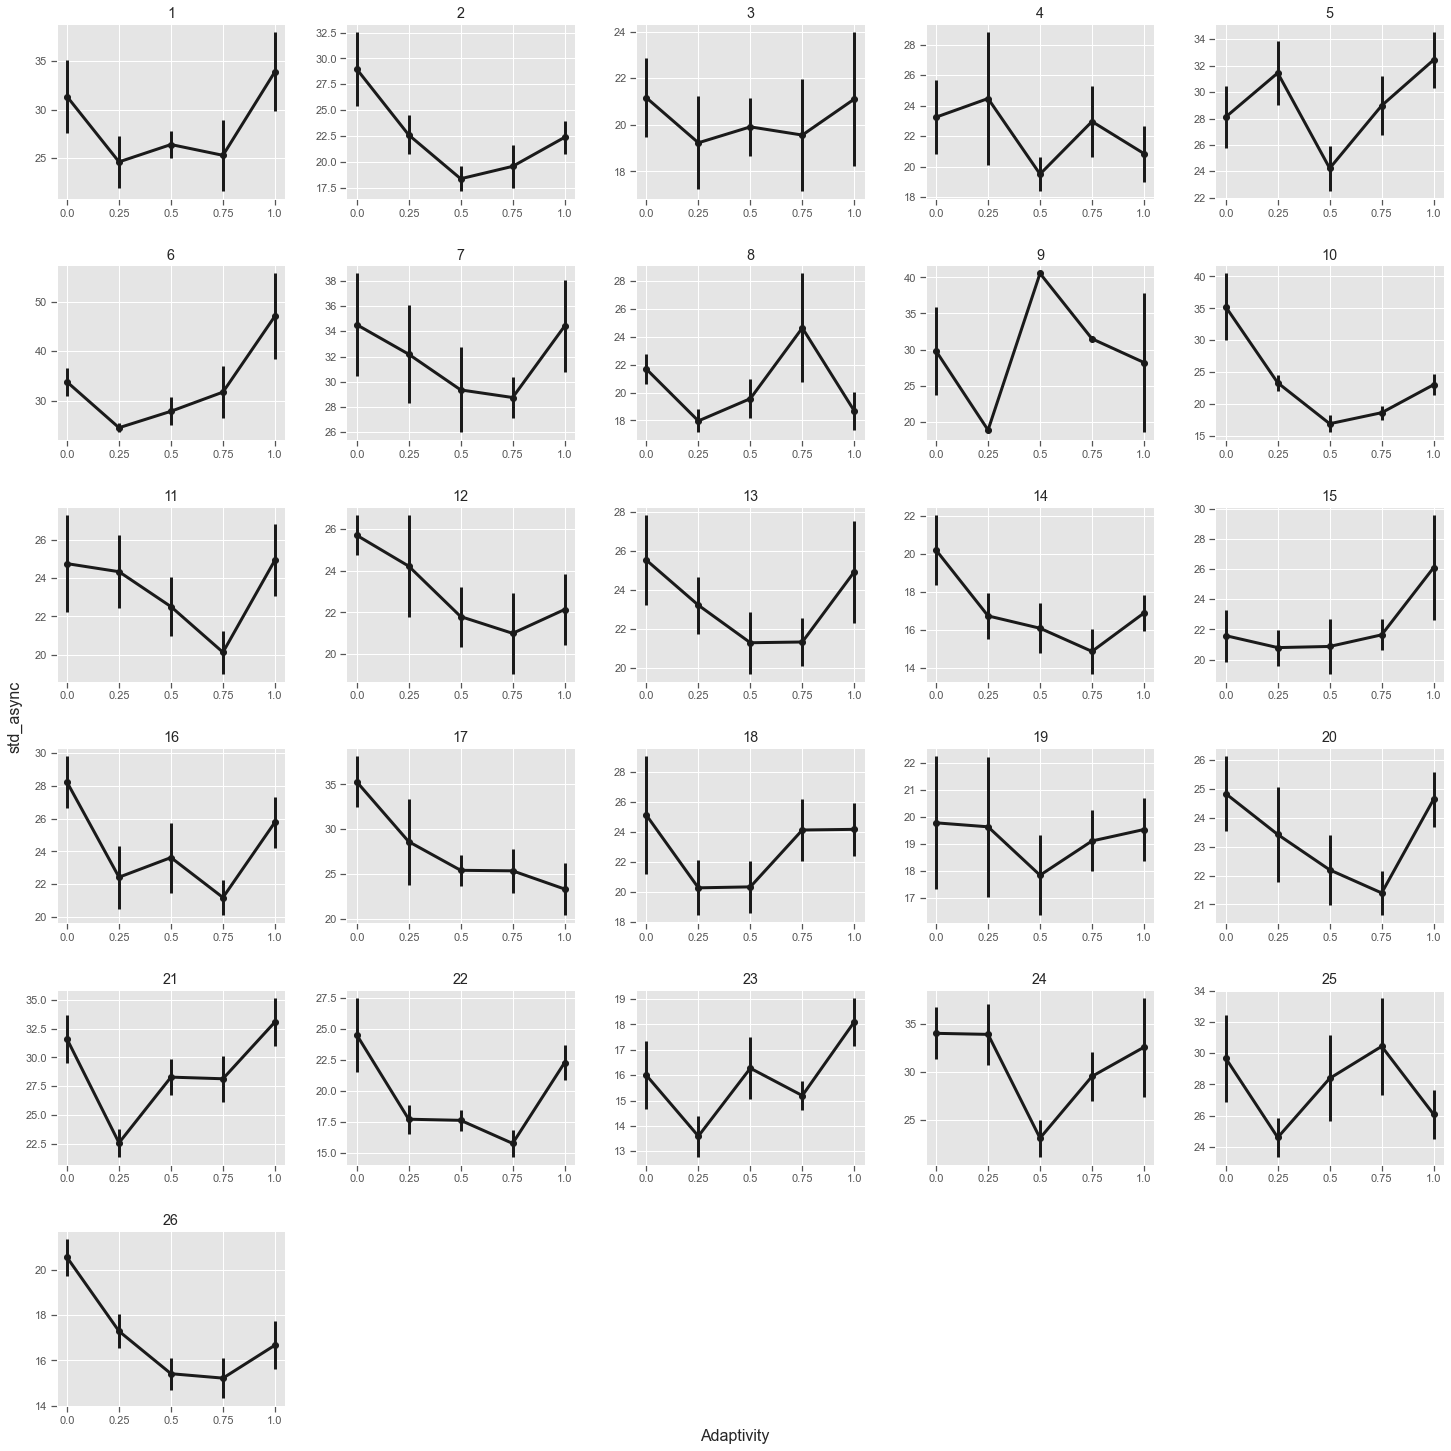

In [152]:
print('\nTapping data for each participant in Experiment 2: \n\n')
df = op.loc[op['expID'] == 2]
plot_all(df, 0, 'std_async')


Tapping data for each group in Experiment 3: 




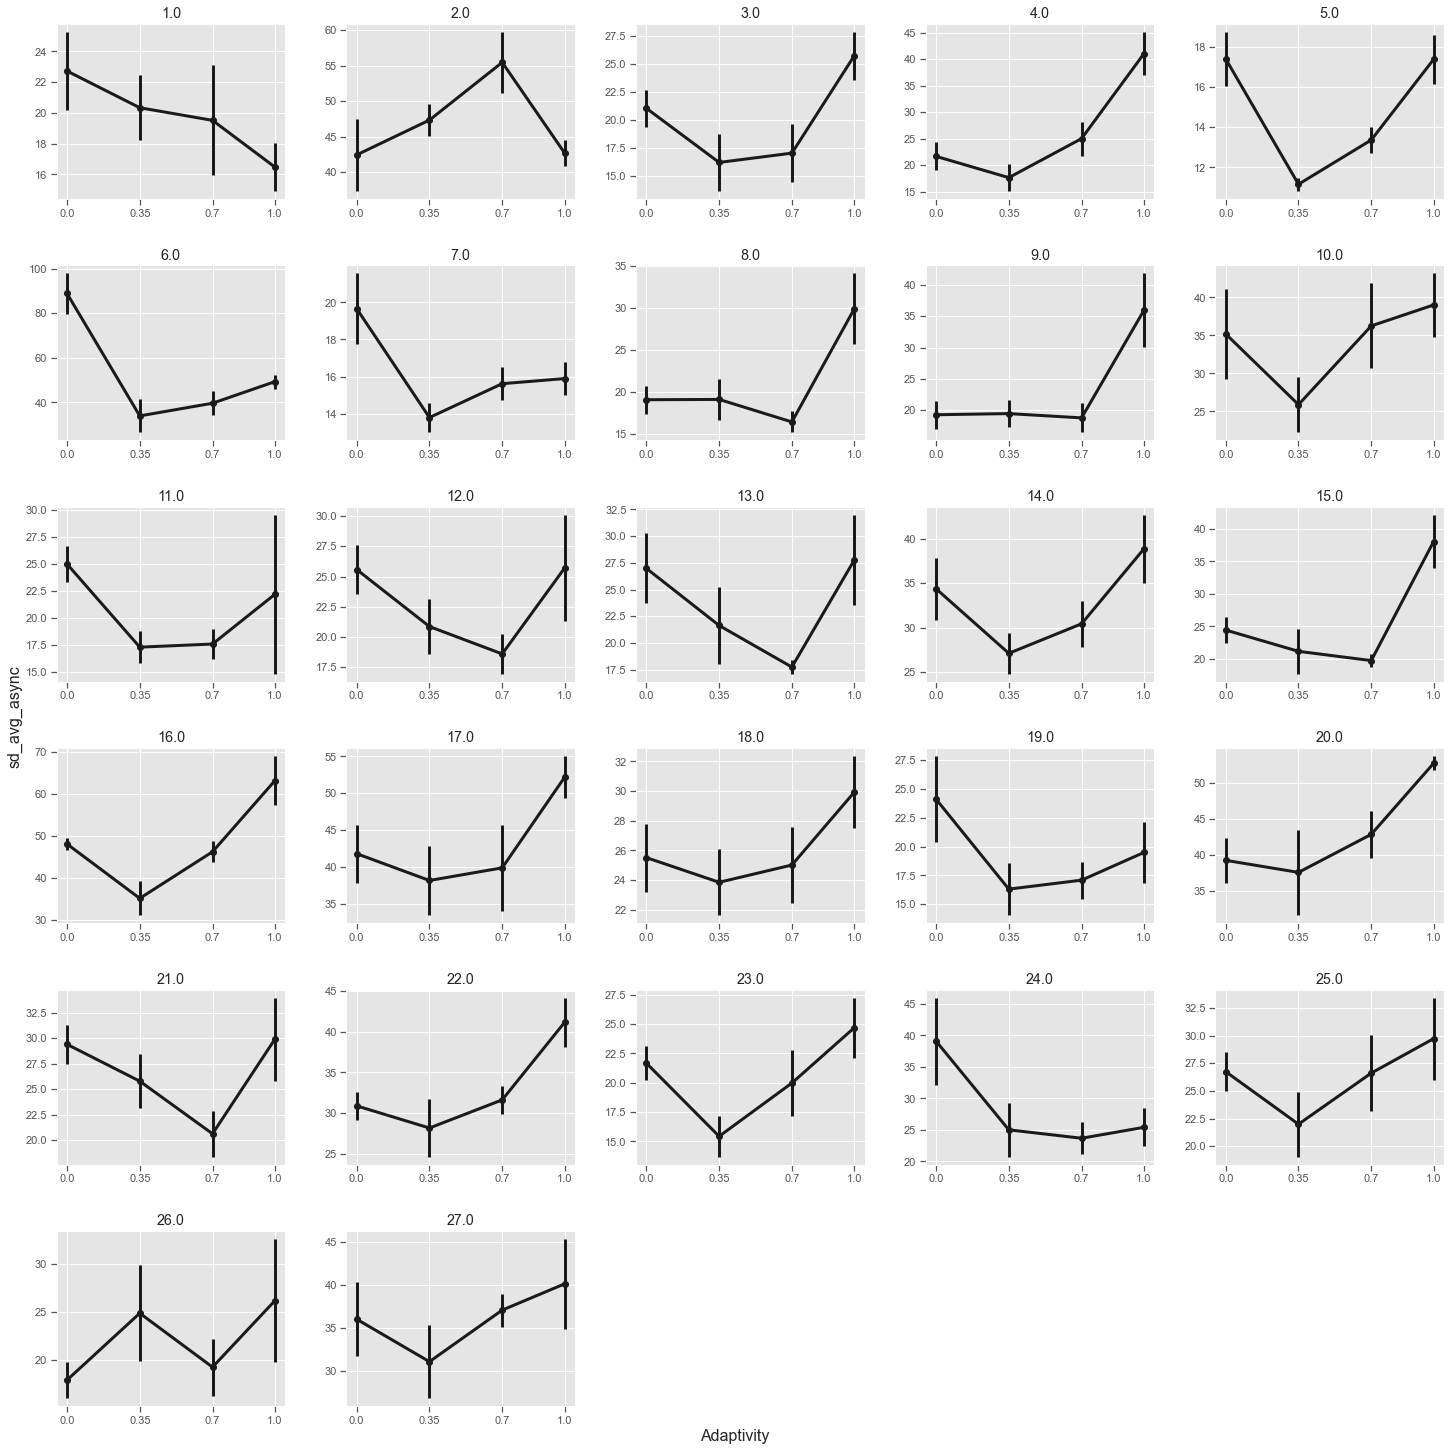

In [153]:
print('\nTapping data for each group in Experiment 3: \n\n')
df = fp.loc[fp['expID'] == 3]
plot_all(df, 1, 'sd_avg_async')


Tapping data for each group in Experiment 4: 




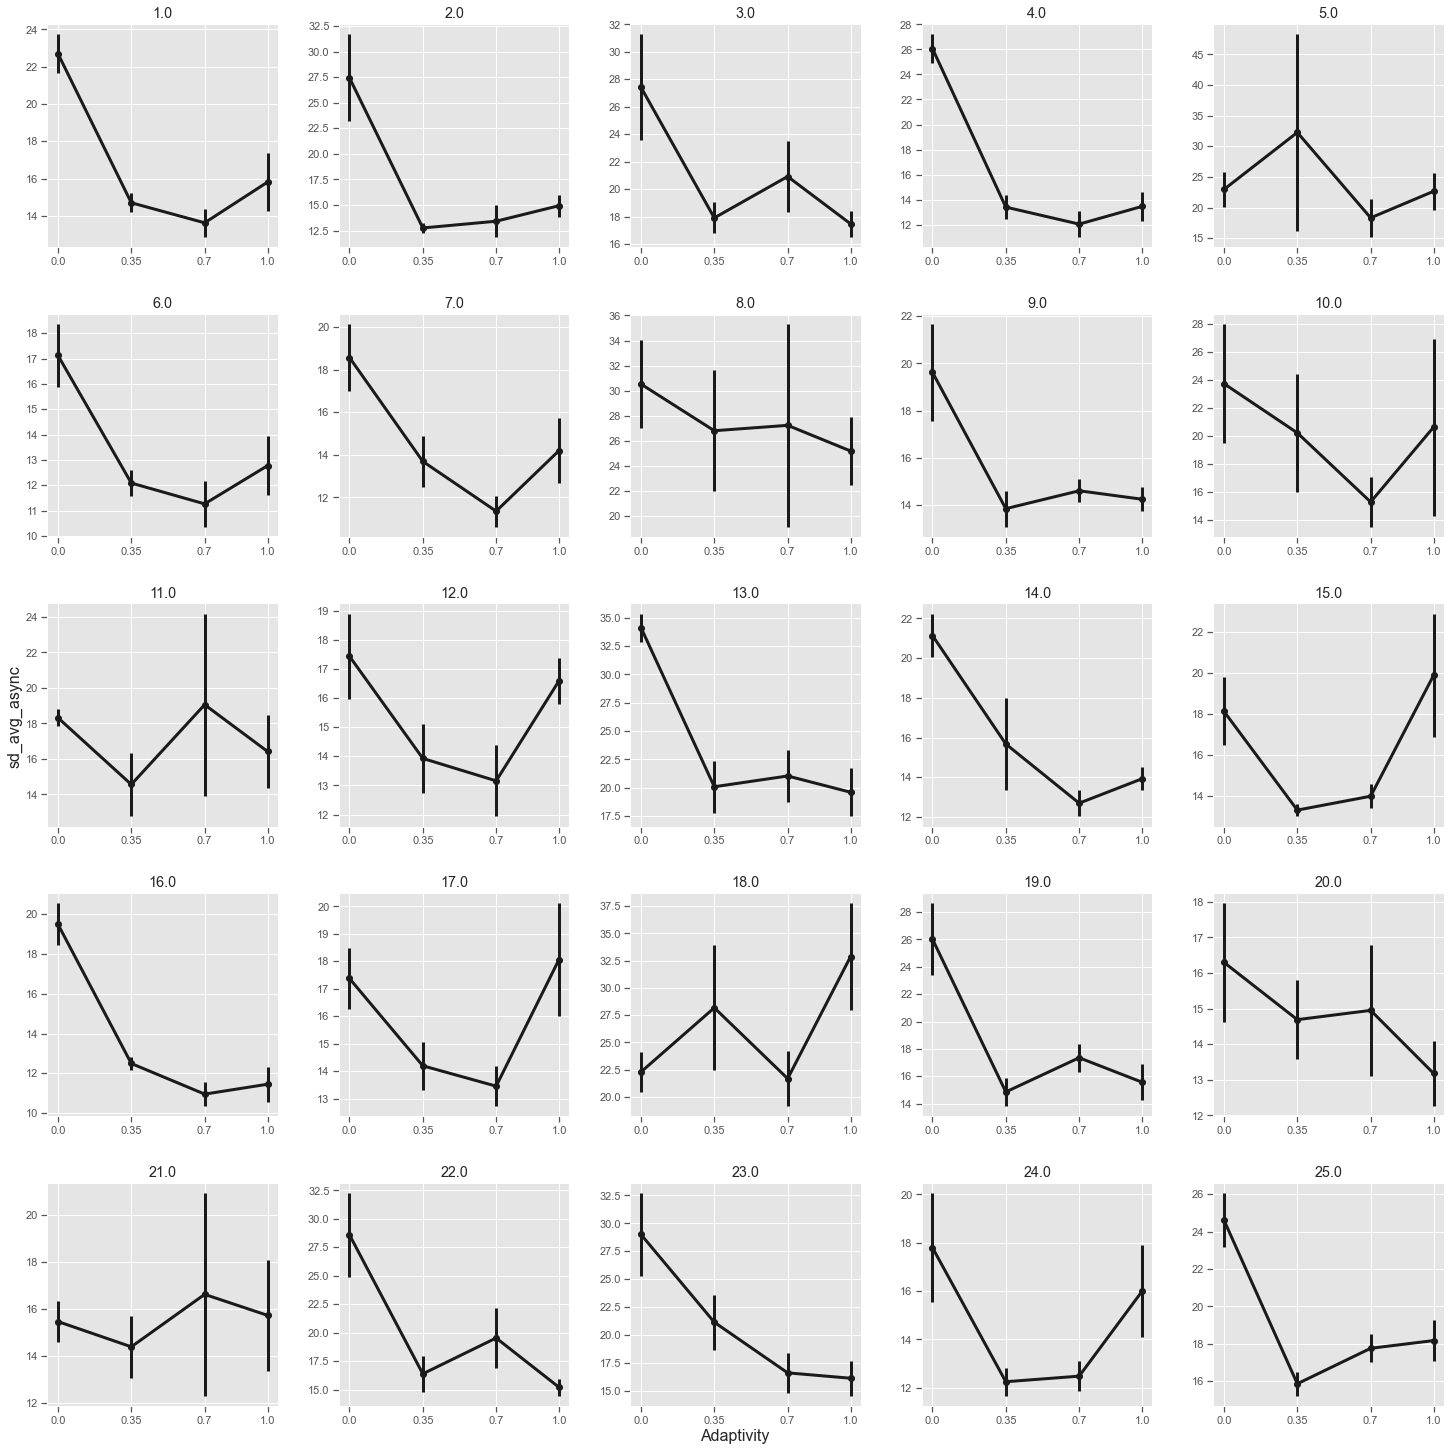

In [154]:
print('\nTapping data for each group in Experiment 4: \n\n')
df = fp.loc[fp['expID'] == 4]
plot_all(df, 1, 'sd_avg_async')


Tapping data for each group in Experiment 5: 




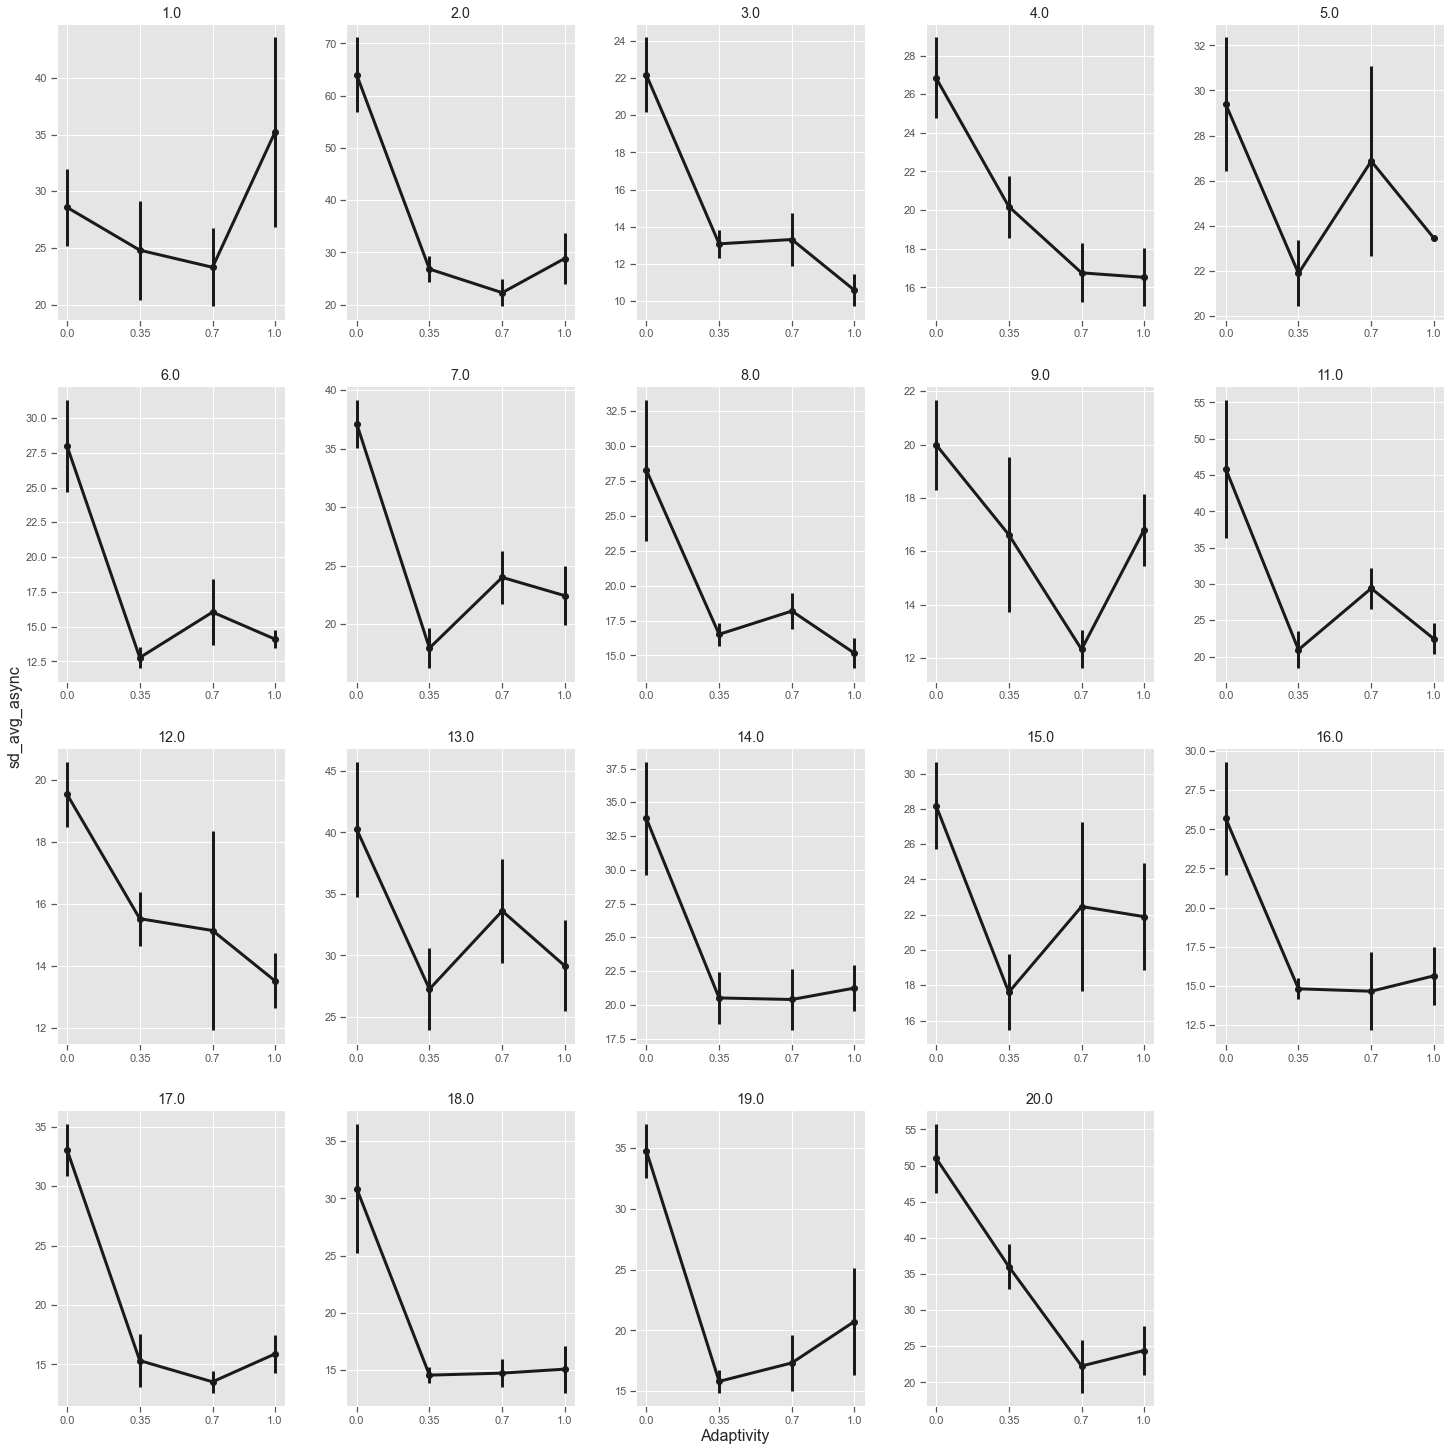

In [155]:
print('\nTapping data for each group in Experiment 5: \n\n')
df = fp.loc[fp['expID'] == 5]
plot_all(df, 1, 'sd_avg_async')

# For each experiment plot tapping data averaged over all participants

            mean       sem  mean-baseline
alpha                                    
0.00   37.231978  4.668134       0.000000
0.25   29.133635  3.989228      -8.098343
0.50   30.592674  4.130978      -6.639304
0.75   33.407185  4.603583      -3.824793
1.00   39.022962  4.921858       1.790984 

            mean       sem  mean-baseline
alpha                                    
0.00   26.739076  1.066073       0.000000
0.25   22.794144  0.951660      -3.944933
0.50   22.454569  1.078241      -4.284507
0.75   22.927839  1.020782      -3.811237
1.00   25.512960  1.332122      -1.226117 

            mean       sem  mean-baseline
alpha                                    
0.00   30.531826  2.774633       0.000000
0.35   24.312008  1.631966      -6.219818
0.70   26.339514  2.128154      -4.192312
1.00   33.349616  2.315286       2.817790 

            mean       sem  mean-baseline
alpha                                    
0.00   22.490324  1.017482       0.000000
0.35   16.788198  1.058540  

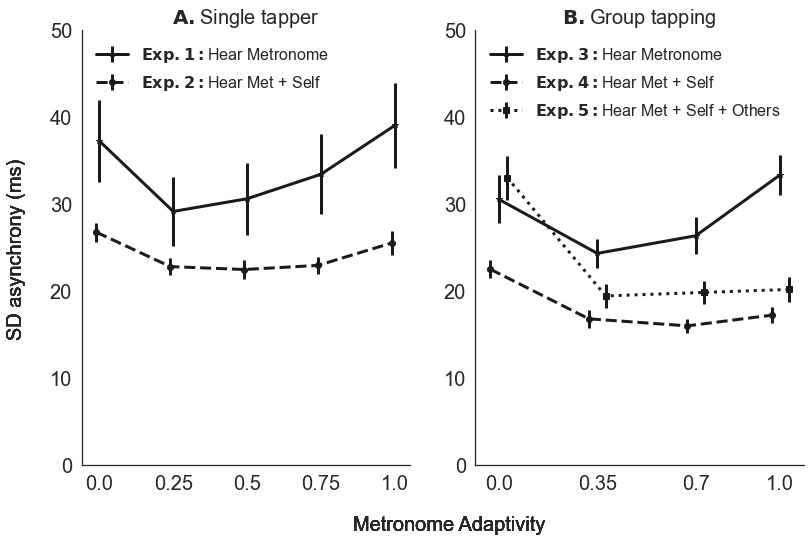

In [194]:
to_zscore = 0 # NOTE: if not z-scoring, be sure to change ylims which are currently optimized for z-scores data
fig = plt.figure(figsize=(20,8))
expIDs = np.array([1,2,3,4,5])
line_defs = ['k*-', 'ko--', 'k*-', 'ko--', 'ks:']
label_defs = [r"$\bf{" + "Exp. 1: " + "}$" + 'Hear Metronome', r"$\bf{" + "Exp. 2: " + "}$" + 'Hear Met + Self', r"$\bf{" + "Exp. 3: " + "}$" + 'Hear Metronome', r"$\bf{" + "Exp. 4: " + "}$" + 'Hear Met + Self', r"$\bf{" + "Exp. 5: " + "}$" + 'Hear Met + Self + Others']
alpha_offset_defs = [0, -.01, 0, -.03, .03]
fsize = 20
sns.set_style("white")
ymin = 0
ymax = 50
yinc = 10

for idx, val in enumerate(expIDs):
    
    # Mask data by experiment
    if val < 3: # single tapper
        df = op.loc[op['expID'] == val]
        col = 'std_async'    
        group = 0
    else: # group tapping
        df = fp.loc[fp['expID'] == val]
        col = 'sd_avg_async'
        group = 1

    # Create plot   
    if val == 1:
        ax = fig.add_subplot(1, 3, 1)
        plt.title(r"$\bf{" + "A. " + "}$" + 'Single tapper', fontsize = fsize)#, horizontalalignment = 'right')
    if val == 3:
        ax = fig.add_subplot(1, 3, 2)
        plt.title(r"$\bf{" + "B. " + "}$" + 'Group tapping', fontsize = fsize)
    data = return_mean_sem(df, group, col, to_zscore)
    print(data, '\n')
    ax.errorbar(data.index.values+alpha_offset_defs[idx], data['mean'], yerr = data['sem'], fmt=line_defs[idx], label=label_defs[idx])  
    ax.set_xticks(data.index.values)
    ax.set_xticklabels(data.index.values, fontsize = fsize)
    ax.set_ylim(ymin, ymax) 
    ax.set_yticklabels(np.arange(ymin,ymax+1,yinc), fontsize = fsize)
    ax.legend(fontsize = 16, frameon=False, loc = 'upper left')
    fig.text(0.38, 0.02, 'Metronome Adaptivity', ha='center', va='center', fontsize=fsize)
    fig.text(0.08, 0.5, 'SD asynchrony (ms)', ha='center', va='center', rotation='vertical', fontsize=fsize)
    
sns.despine()   
sns.set(style="ticks", rc={"lines.linewidth": 3})
plt.savefig('Figures/allExp_tapping_plots.eps', dpi=1200, bbox_inches = 'tight',
    pad_inches = 0.5)


# Compute tapping statistics
We are interested in whether there is a significant difference in tapping performance between alpha conditions. Therefore, we can use an ANOVA. In our case, we will use a repeated measures ANOVA because we have multiple observations for each alpha condition (repeated measures) for each participant or group. 

In the output below, the headers correspond to the following:

- 'Source' : Name of the within-group factor
- 'SS' : Sum of squares
- 'DF' : Degrees of freedom 
- 'MS' : Mean squares
- 'F' : F-value
- 'p-unc' : Uncorrected p-value
- 'p-GG-corr' : Greenhouse-Geisser corrected p-value
- 'np2' : Partial eta-square effect size
- 'eps' : Greenhouse-Geisser epsilon factor (= index of sphericity)
- 'sphericity' : sphericity of the data (boolean)
- 'W-spher' : Sphericity test statistic
- 'p-spher' : p-value of the sphericity test

In the post-hoc t-tests, we use hedges g for effect size. This is similar to Cohen's d but considered more appropriate for sample sizes < 20. Effect sizes should be interpretted as follows: 
- Small effect (cannot be discerned by the naked eye) = 0.2
- Medium Effect = 0.5
- Large Effect (can be seen by the naked eye) = 0.8


Let's first do this for data from Experiment 1:


In [157]:
df = op.loc[op['expID'] == 1]
to_zscore = 0
rmaov_results(df, 0, 'std_async', to_zscore)




ANOVA table

  Source        SS  DF       MS      F       p-unc  p-GG-corr    np2    eps  \
0  alpha  1068.658   4  267.164  4.814  0.00208059  0.0115279  0.256  0.578   
1  Error  3108.013  56   55.500      -           -          -      -      -   

  sphericity W-spher     p-spher  
0      False   0.164  0.00809273  
1          -       -           -  


Post-hoc comparisons between all means



,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,alpha,0.00,0.25,True,True,2.808,14.0,one-sided,0.006982,0.048874,holm,8.477,0.483
1,alpha,0.00,0.50,True,True,2.923,14.0,one-sided,0.005566,0.044527,holm,10.201,0.390
2,alpha,0.00,0.75,True,True,1.267,14.0,one-sided,0.112951,0.338853,holm,1.03,0.213
3,alpha,0.00,1.00,True,True,-0.433,14.0,one-sided,0.335825,0.493078,holm,0.57,-0.096
4,alpha,0.25,0.50,True,True,-0.704,14.0,one-sided,0.246539,0.493078,holm,0.651,-0.093
5,alpha,0.25,0.75,True,True,-1.557,14.0,one-sided,0.070913,0.283652,holm,1.416,-0.257
6,alpha,0.25,1.00,True,True,-3.828,14.0,one-sided,0.000923,0.009233,holm,45.839,-0.573
7,alpha,0.50,0.75,True,True,-1.918,14.0,one-sided,0.037839,0.189196,holm,2.242,-0.166
8,alpha,0.50,1.00,True,True,-3.184,14.0,one-sided,0.003313,0.029818,holm,15.651,-0.481
9,alpha,0.75,1.00,True,True,-2.182,14.0,one-sided,0.023317,0.139904,holm,3.244,-0.304


In [158]:
print('\n\nExperiment 2:')
rmaov_results(op.loc[op['expID'] == 2], 0, 'std_async', to_zscore)



Experiment 2:



ANOVA table

  Source        SS   DF      MS      F        p-unc    p-GG-corr    np2  \
0  alpha   383.417    4  95.854  8.692  4.61008e-06  5.11635e-05  0.258   
1  Error  1102.800  100  11.028      -            -            -      -   

     eps sphericity W-spher     p-spher  
0  0.749      False   0.392  0.00935125  
1      -          -       -           -  


Post-hoc comparisons between all means



,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,alpha,0.00,0.25,True,True,5.325,25.0,one-sided,0.000008,0.000081,holm,2787.128,0.767
1,alpha,0.00,0.50,True,True,4.389,25.0,one-sided,0.000091,0.000727,holm,312.24,0.784
2,alpha,0.00,0.75,True,True,4.514,25.0,one-sided,0.000066,0.000591,holm,418.012,0.716
3,alpha,0.00,1.00,True,True,1.269,25.0,one-sided,0.108024,0.432094,holm,0.851,0.201
4,alpha,0.25,0.50,True,True,0.300,25.0,one-sided,0.383350,0.766701,holm,0.432,0.066
5,alpha,0.25,0.75,True,True,-0.157,25.0,one-sided,0.438142,0.766701,holm,0.419,-0.027
6,alpha,0.25,1.00,True,True,-2.519,25.0,one-sided,0.009277,0.046385,holm,5.636,-0.467
7,alpha,0.50,0.75,True,True,-0.781,25.0,one-sided,0.221064,0.663191,holm,0.547,-0.088
8,alpha,0.50,1.00,True,True,-2.932,25.0,one-sided,0.003552,0.021311,holm,12.606,-0.498
9,alpha,0.75,1.00,True,True,-3.067,25.0,one-sided,0.002567,0.017969,holm,16.626,-0.431


In [159]:
print('\n\nExperiment 3:')
rmaov_results(fp.loc[fp['expID'] == 3], 1, 'sd_avg_async', to_zscore)



Experiment 3:



ANOVA table

  Source        SS  DF       MS       F        p-unc    p-GG-corr    np2  \
0  alpha  1344.143   3  448.048  11.331  3.00913e-06  9.43737e-05  0.304   
1  Error  3084.257  78   39.542       -            -            -      -   

     eps sphericity W-spher      p-spher  
0  0.653      False   0.362  0.000132394  
1      -          -       -            -  


Post-hoc comparisons between all means



,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,alpha,0.00,0.35,True,True,3.019,26.0,one-sided,2.813093e-03,0.011252,holm,15.198,0.543
1,alpha,0.00,0.70,True,True,2.092,26.0,one-sided,2.319267e-02,0.046385,holm,2.643,0.329
2,alpha,0.00,1.00,True,True,-1.285,26.0,one-sided,1.050676e-01,0.105068,holm,0.853,-0.213
3,alpha,0.35,0.70,True,True,-2.393,26.0,one-sided,1.211531e-02,0.036346,holm,4.466,-0.208
4,alpha,0.35,1.00,True,True,-6.225,26.0,one-sided,6.906053e-07,0.000004,holm,2.64e+04,-0.881
5,alpha,0.70,1.00,True,True,-5.414,26.0,one-sided,5.652889e-06,0.000028,holm,3830.321,-0.607


In [160]:
print('\n\nExperiment 4:')
rmaov_results(fp.loc[fp['expID'] == 4], 1, 'sd_avg_async', to_zscore)



Experiment 4:



ANOVA table

  Source       SS  DF       MS       F        p-unc    p-GG-corr    np2  \
0  alpha  657.567   3  219.189  22.095  3.00473e-10  2.00551e-07  0.479   
1  Error  714.270  72    9.920       -            -            -      -   

     eps sphericity W-spher     p-spher  
0  0.654      False   0.456  0.00319558  
1      -          -       -           -  


Post-hoc comparisons between all means



,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,alpha,0.00,0.35,True,True,5.170,24.0,one-sided,1.350818e-05,6.754089e-05,holm,1751.308,1.099
1,alpha,0.00,0.70,True,True,7.707,24.0,one-sided,3.033231e-08,1.819939e-07,holm,4.794e+05,1.434
2,alpha,0.00,1.00,True,True,4.508,24.0,one-sided,7.264061e-05,2.905625e-04,holm,384.458,1.097
3,alpha,0.35,0.70,True,True,1.073,24.0,one-sided,1.470244e-01,2.940488e-01,holm,0.707,0.175
4,alpha,0.35,1.00,True,True,-0.656,24.0,one-sided,2.589229e-01,2.940488e-01,holm,0.513,-0.085
5,alpha,0.70,1.00,True,True,-1.777,24.0,one-sided,4.414424e-02,1.324327e-01,holm,1.65,-0.288


In [161]:
print('\n\nExperiment 5:')
rmaov_results(fp.loc[fp['expID'] == 5], 1, 'sd_avg_async', to_zscore)



Experiment 5:



ANOVA table

  Source        SS  DF       MS      F        p-unc    p-GG-corr    np2   eps  \
0  alpha  2497.444   3  832.481  33.73  2.02612e-12  4.48566e-08  0.652  0.58   
1  Error  1332.767  54   24.681      -            -            -      -     -   

  sphericity W-spher     p-spher  
0      False   0.338  0.00285362  
1          -       -           -  


Post-hoc comparisons between all means



,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,alpha,0.00,0.35,True,True,7.291,18.0,one-sided,4.478712e-07,0.000003,holm,3.956e+04,1.607
1,alpha,0.00,0.70,True,True,6.187,18.0,one-sided,3.852441e-06,0.000018,holm,5589.309,1.560
2,alpha,0.00,1.00,True,True,6.226,18.0,one-sided,3.555409e-06,0.000018,holm,6010.171,1.485
3,alpha,0.35,0.70,True,True,-0.347,18.0,one-sided,3.663028e-01,0.730203,holm,0.501,-0.068
4,alpha,0.35,1.00,True,True,-0.751,18.0,one-sided,2.313023e-01,0.693907,holm,0.61,-0.122
5,alpha,0.70,1.00,True,True,-0.350,18.0,one-sided,3.651015e-01,0.730203,holm,0.502,-0.056


### Compare tapping results between experiments
Conduct ANOVA with exp as predictor and async as outcome

In [162]:
# single player experiments
print('\n\n\nSingle tapper experiments\n')
means = op.groupby(['subID', 'alpha', 'expID'], as_index=False)['std_async'].mean()
print('ANOVA result:\n')
print(means.anova(dv="std_async", between=["expID"]))
print('\n\n')
print('Post-hoc contrasts:\n')
print(pg.pairwise_ttests(dv='std_async', between='expID', data=means, alpha = .05, tail = 'one-sided', padjust = 'holm', effsize = 'cohen'))

ex1 = return_mean_sem(op.loc[op['expID'] == 1], 0, 'std_async', 0)
ex2 = return_mean_sem(op.loc[op['expID'] == 2], 0, 'std_async', 0)

print('\n\nDifference between overall means Exp. 1 vs. 2:\n')
print(ex2['mean'].mean() - ex1['mean'].mean())


# group experiments
print('\n\n\nGroup experiments\n')
means = fp.groupby(['group', 'alpha', 'expID'], as_index=False)['sd_avg_async'].mean()
print('ANOVA result:\n')
print(means.anova(dv="sd_avg_async", between=["expID"]))
print('\n\n')
print('Post-hoc contrasts:\n')
print(pg.pairwise_ttests(dv='sd_avg_async', between='expID', data=means, alpha = .05, tail = 'one-sided', padjust = 'holm', effsize = 'cohen'))

ex3 = return_mean_sem(fp.loc[fp['expID'] == 3], 1, 'sd_avg_async', 0)
ex4 = return_mean_sem(fp.loc[fp['expID'] == 4], 1, 'sd_avg_async', 0)
ex5 = return_mean_sem(fp.loc[fp['expID'] == 5], 1, 'sd_avg_async', 0)

print('\n\nDifference between overall means Exp. 3 vs. 4:\n')
print(ex4['mean'].mean() - ex3['mean'].mean())

print('\n\nDifference between overall means Exp. 4 vs. 5:\n')
print(ex5['mean'].mean() - ex4['mean'].mean())

print('\n\nDifference between overall means Exp. 3 vs. 5:\n')
print(ex5['mean'].mean() - ex3['mean'].mean())




Single tapper experiments

ANOVA result:

  Source  ddof1  ddof2       F         p-unc    np2
0  expID      1    203  35.059  1.347533e-08  0.147



Post-hoc contrasts:

  Contrast  A  B  Paired  Parametric      T    dof       Tail     p-unc  \
0    expID  1  2   False        True  4.756  83.63  one-sided  0.000004   

       BF10  cohen  
0  8159.535  0.859  


Difference between overall means Exp. 1 vs. 2:

-9.79196927930666



Group experiments

ANOVA result:

  Source  ddof1  ddof2       F         p-unc    np2
0  expID      2    281  32.291  2.381442e-13  0.187



Post-hoc contrasts:

  Contrast    A    B  Paired  Parametric      T     dof       Tail  \
0    expID  3.0  5.0   False        True  3.485  179.97  one-sided   
1    expID  3.0  4.0   False        True  8.232  149.96  one-sided   
2    expID  5.0  4.0   False        True  4.142  111.19  one-sided   

          p-unc        p-corr p-adjust       BF10  cohen  
0  3.094987e-04  3.094987e-04     holm     81.301  0.500  
1 

# Ratings data 

Let's now look at the ratings data for all experiments. In the single tapper experiments, we have:
- how in the groove participants felt
- how in synchrony with the metronome participants felt
- how much participants would like to continue the task
- how difficult participants found the task
- participants' degree of felt influence over the pulse

In the group experiments, we have all of the above, plus:
- how in synchrony the particpant felt with the other participants



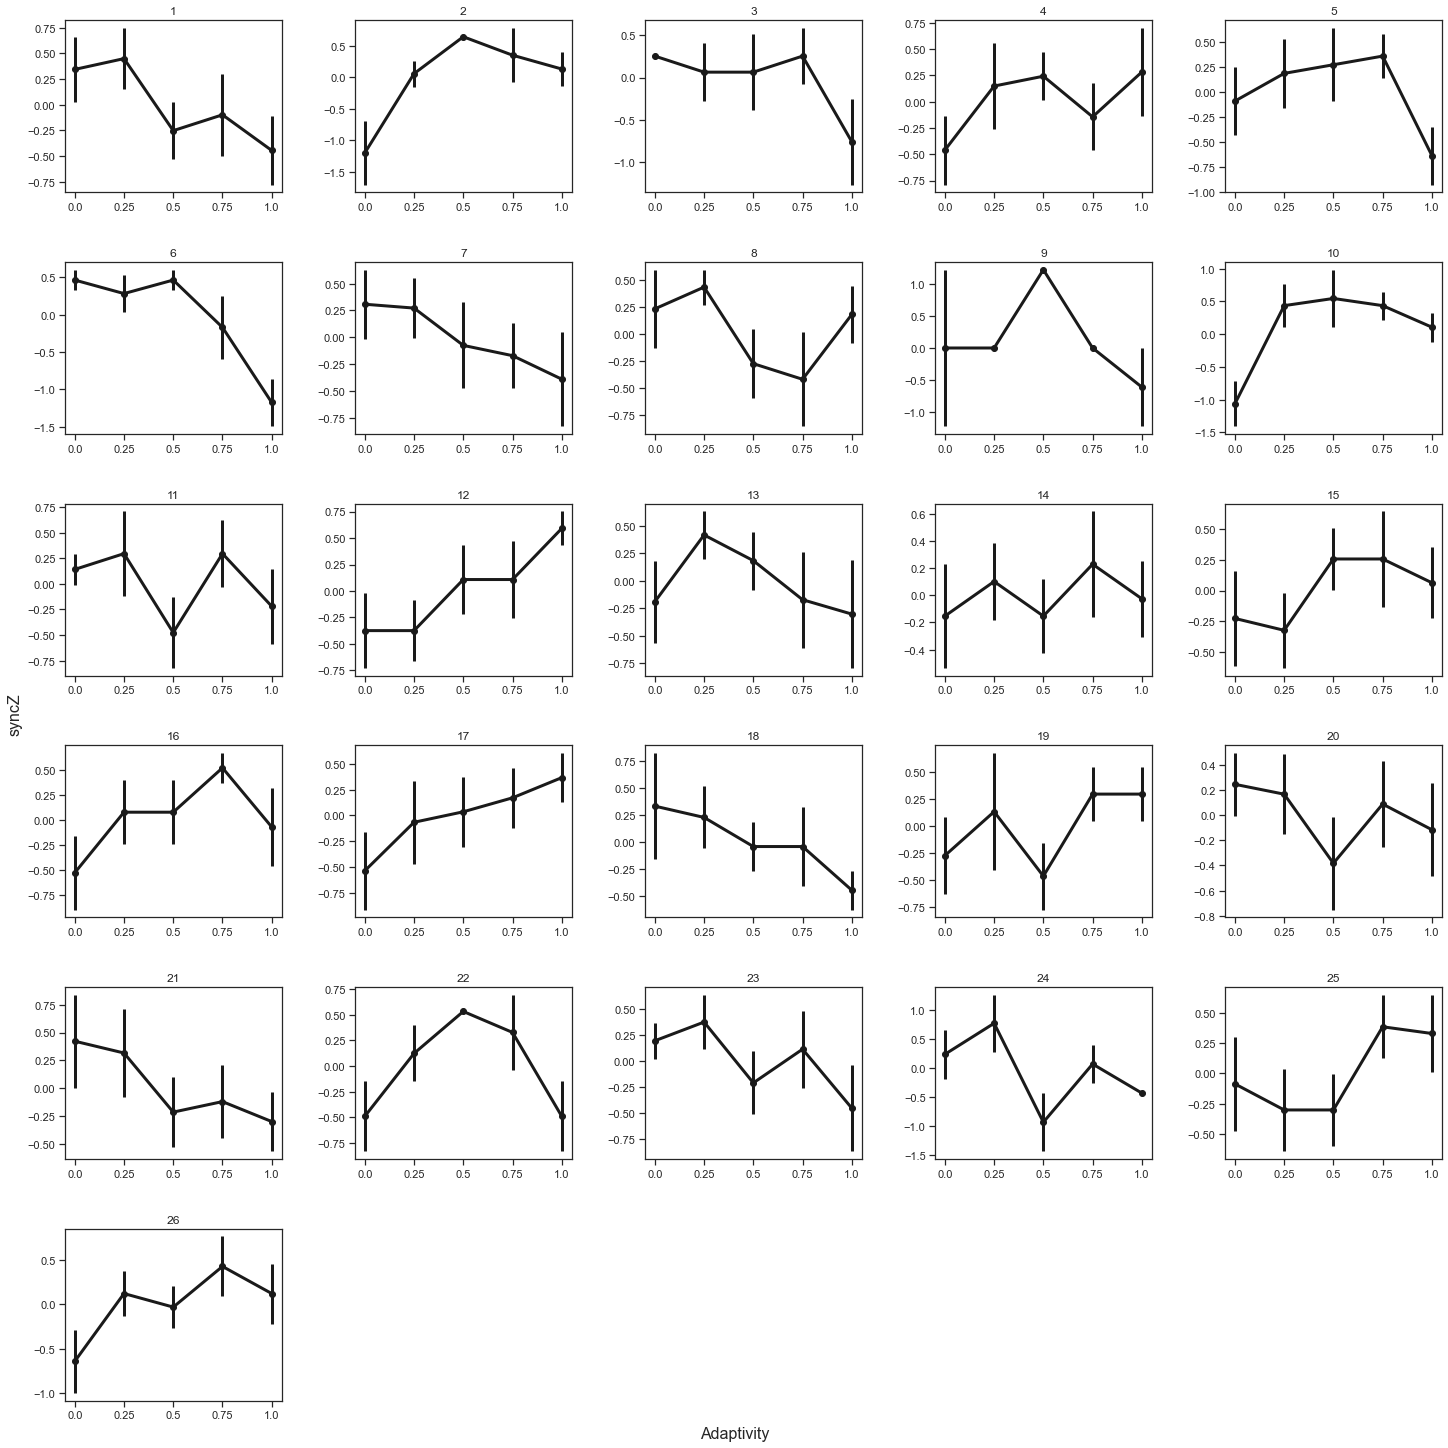

In [163]:
# If want to look at individual participant data for any given experiment and rating, 
# just input exp ID and rating column label
df = op.loc[op['expID'] == 2]
plot_all(df, 0, 'syncZ')

### How well do subjective feelings of synchrony correlate with measured tapping synchrony?

In [164]:
# For each experiment, compute the correlation between std async and inSync rating
expIDs = np.array([1,2,3,4,5])
for idx, val in enumerate(expIDs):
   
    if val < 3: # single tapper
            df = op.loc[op['expID'] == val]
            col1 = 'std_async' 
            col2 = 'syncZ'
            group = 'subID'
    else: # group tapping
            df = fp.loc[fp['expID'] == val]
            col1 = 'sd_avg_async'
            col2 = 'group_sync_self'
            group = 'group_num'
    
    print('Experiment: %d' % val)
    print(pg.rm_corr(data=df, x=col1, y=col2, subject=group))
    #pg.plot_rm_corr(data=df, x=col1, y=col2, subject=group)
    print('\n\n')

Experiment: 1
             r  dof          pval           CI95%  power
rm_corr -0.402  603  6.022954e-25  [-0.47, -0.33]    1.0



Experiment: 2
             r   dof          pval           CI95%  power
rm_corr -0.304  1085  1.047082e-24  [-0.36, -0.25]    1.0



Experiment: 3


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


             r  dof          pval           CI95%  power
rm_corr -0.422  605  1.489275e-27  [-0.48, -0.35]    1.0



Experiment: 4
             r  dof          pval           CI95%  power
rm_corr -0.243  541  9.665132e-09  [-0.32, -0.16]    1.0



Experiment: 5
             r  dof      pval           CI95%  power
rm_corr -0.163  407  0.000944  [-0.26, -0.07]  0.912





In [165]:
# We can also relate the tapping asynchrony of the group members with respect to each other 
# and their rating of being in sync with the group
expIDs = np.array([3,4,5])
for idx, val in enumerate(expIDs):
    df = fp.loc[fp['expID'] == val]
    col1 = 'avg_std_async'
    col2 = 'group_sync_others'
    group = 'group_num'
    print('Experiment: %d' % val)
    print(pg.rm_corr(data=df, x=col1, y=col2, subject=group))
    #pg.plot_rm_corr(data=df, x=col1, y=col2, subject=group)
    print('\n\n')

Experiment: 3
             r  dof          pval           CI95%  power
rm_corr -0.265  605  3.360762e-11  [-0.34, -0.19]    1.0



Experiment: 4
             r  dof          pval          CI95%  power
rm_corr -0.284  541  1.686526e-11  [-0.36, -0.2]    1.0



Experiment: 5
             r  dof          pval          CI95%  power
rm_corr -0.385  407  7.258684e-16  [-0.46, -0.3]    1.0





### Check correlations between all rating scales

In [166]:
# print correlation tables for each experiment
expIDs = np.array([1,2,3,4,5])
for idx, val in enumerate(expIDs):
    print('\nPearson correlation coefficients for all ratings in Exp:', val)
    if val < 3:
        df = op.loc[op['expID'] == val]
        means = df.groupby(['subID', 'alpha'], as_index=False)['grooveZ', 'syncZ', 'likeZ', 'diffZ', 'inflZ'].mean()
        sdf = means[['grooveZ', 'syncZ', 'likeZ', 'diffZ', 'inflZ']].copy()
        print(sdf.rcorr(method='pearson', padjust='fdr_bh'))

    else:
        df = fp.loc[fp['expID'] == val]
        means = df.groupby(['group_num', 'alpha'], as_index=False)['group_groove', 'group_sync_self', 'group_cont', 'group_diff', 'group_infl', 'group_sync_others'].mean()
        sdf = means[['group_groove', 'group_sync_self', 'group_cont', 'group_diff', 'group_infl', 'group_sync_others']].copy()
        print(sdf.rcorr(method='pearson', padjust='fdr_bh'))



Pearson correlation coefficients for all ratings in Exp: 1
        grooveZ   syncZ   likeZ   diffZ inflZ
grooveZ       -     ***     ***     ***    **
syncZ     0.786       -     ***     ***     *
likeZ     0.664   0.566       -     ***     *
diffZ    -0.769  -0.872  -0.524       -      
inflZ     0.354    0.24   0.289  -0.186     -

Pearson correlation coefficients for all ratings in Exp: 2
        grooveZ   syncZ   likeZ  diffZ inflZ
grooveZ       -     ***     ***    ***      
syncZ       0.5       -     ***    ***   ***
likeZ     0.365   0.528       -    ***   ***
diffZ    -0.416  -0.614  -0.483      -   ***
inflZ     0.121   0.299   0.438  -0.29     -

Pearson correlation coefficients for all ratings in Exp: 3
                  group_groove group_sync_self group_cont group_diff  \
group_groove                 -             ***        ***        ***   
group_sync_self          0.952               -        ***        ***   
group_cont               0.808           0.769          - 

In [262]:
# Pool across single and group experiments to reduce amount of info in paper
print('Single Tapper Exps.:\n')
meansS = op.groupby(['expID', 'subID', 'alpha'], as_index=False)['grooveZ', 'syncZ', 'likeZ', 'diffZ', 'inflZ'].mean()
sdfS = meansS[['grooveZ', 'syncZ', 'likeZ', 'diffZ', 'inflZ']].copy()
print(sdfS.rcorr(method='pearson', padjust='fdr_bh'))

print('\n\nGroup Tapping Exps.:\n')
meansG = fp.groupby(['expID', 'group_num', 'alpha'], as_index=False)[['group_groove', 'group_sync_self', 'group_cont', 'group_diff', 'group_infl', 'group_sync_others'].copy()].mean()
sdfG = meansG[['group_groove', 'group_sync_self', 'group_cont', 'group_diff', 'group_infl', 'group_sync_others']].copy()
print(sdfG.rcorr(method='pearson', padjust='fdr_bh'))

Single Tapper Exps.:

        grooveZ   syncZ   likeZ   diffZ inflZ
grooveZ       -     ***     ***     ***   ***
syncZ     0.649       -     ***     ***   ***
likeZ     0.511   0.546       -     ***   ***
diffZ    -0.602  -0.755  -0.502       -   ***
inflZ     0.243   0.267   0.362  -0.233     -


Group Tapping Exps.:

                  group_groove group_sync_self group_cont group_diff  \
group_groove                 -             ***        ***        ***   
group_sync_self          0.884               -        ***        ***   
group_cont               0.639           0.607          -        ***   
group_diff              -0.785          -0.844     -0.533          -   
group_infl               0.614           0.596      0.506     -0.482   
group_sync_others        0.772           0.817      0.548     -0.759   

                  group_infl group_sync_others  
group_groove             ***               ***  
group_sync_self          ***               ***  
group_cont               *

### Factor Analysis of ratings

In [279]:
# TODO FACTOR ANALYSIS
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# subset data into ratings
opd = op[['grooveZ', 'syncZ', 'likeZ', 'diffZ', 'inflZ']].copy()
fpd = fp[['group_groove', 'group_sync_self', 'group_cont', 'group_diff', 'group_infl', 'group_sync_others']].copy()
fpd = fpd.dropna() # seems to be one row where nan in gpd
fp = fp.dropna() # also drop this from our main data frame

# TODO delete
# Question: Should the FA be on all the data points or on the means? for each sub / group? 
# opd = sdfS
# fpd = sdfG
# factor structure seems to be about the same when using means. so let's stick with more data. 
# so that we can transform on the trial level

# check if data are suitable for factor analysis
frames = [opd, fpd]
for df in frames: 
    chi_square_value,p_value=calculate_bartlett_sphericity(df) 
    chi_square_value, p_value
    print('Bartlett’s test of sphericity: ', chi_square_value, '\np value: ', p_value, '\ndf:', df.shape[0]-1)
    if p_value > .05:
        print('\nProbably should not do factor analysis')
    else: 
        print('\nResults are fine. Ok to proceed.\n\n')
        
    kmo_all,kmo_model=calculate_kmo(df)
    print('Kaiser-Meyer-Olkin (KMO) Test: ', kmo_model)
    if kmo_model < .6:
        print('\nProbably should not do factor analysis')
    else: 
        print('\nResults are fine. Ok to proceed.\n\n')


Bartlett’s test of sphericity:  2092.278839185159 
p value:  0.0 
df: 1730

Results are fine. Ok to proceed.


Kaiser-Meyer-Olkin (KMO) Test:  0.7334216443393283

Results are fine. Ok to proceed.


Bartlett’s test of sphericity:  4016.4618161861413 
p value:  0.0 
df: 1626

Results are fine. Ok to proceed.


Kaiser-Meyer-Olkin (KMO) Test:  0.8560323180455057

Results are fine. Ok to proceed.




One player data


Eigenvalues for factors
 [2.45344753 0.97557434 0.73770198 0.48306176 0.35021438] 

1 eigenvalue(s) are > 1. Therefore, proceed with 1 factor(s).

Factor Loadings:
       Item        F1  communalities
0  grooveZ -0.689297       0.475131
1    syncZ -0.835226       0.697603
2    likeZ -0.433075       0.187554
3    diffZ  0.715922       0.512544
4    inflZ  -0.25286       0.063938

variance:
 Factor variances, proportional variance, cumulative variances
 (array([1.93677042]), array([0.38735408]), array([0.38735408]))



Group data


Eigenvalues for factors
 [3.38312774 0.87165392 0.64560951 0.45625073 0.40026313 0.24309496] 

1 eigenvalue(s) are > 1. Therefore, proceed with 1 factor(s).

Factor Loadings:
                 Item        F1  communalities
0       group_groove -0.807674       0.652337
1    group_sync_self -0.905058       0.819130
2         group_cont -0.478331       0.228801
3         group_diff   0.69058       0.476901
4         group_infl -0.498261       0.2

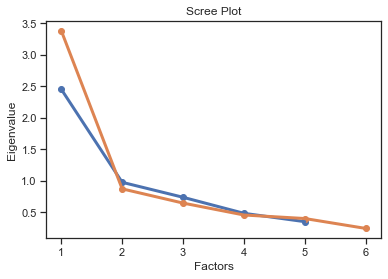

In [280]:
def factor_df(df):
    # Create factor analysis object and perform factor analysis
    fa = FactorAnalyzer(rotation=None)
    fa.fit(df)

    # Check Eigenvalues
    ev, v = fa.get_eigenvalues()
    print('Eigenvalues for factors\n', ev, '\n')
    #print(v)
    nfactors = sum(ev > 1)
    print(nfactors, 'eigenvalue(s) are > 1. Therefore, proceed with', nfactors, 'factor(s).')

    # Plot scree if we want
    plt.scatter(range(1,df.shape[1]+1),ev)
    plt.plot(range(1,df.shape[1]+1),ev)
    plt.title('Scree Plot')
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    
    # Now do fa again and specify number of factors
    fa = FactorAnalyzer(n_factors=nfactors, method='ml', rotation=None) #no rotation when only one factor
    fa.fit(df)
    loadings = fa.loadings_
    communalities = fa.get_communalities()
    variance = fa.get_factor_variance()
    
    # create new column labels based on number of factors 
    factorLabels = list()
    factorLabels.append('Item')
    for i in range(nfactors):
        factorLabels.append('F' + str(i+1))

    loading_DF = pd.DataFrame(columns = factorLabels)
    loading_DF['Item'] = df.columns
    for i, c in enumerate(df.columns):
        loading_DF.iloc[i, 1:nfactors+1] = loadings[i]
    loading_DF['communalities'] = communalities
    print('\nFactor Loadings:\n', loading_DF)
    
    print('\nvariance:\n', 'Factor variances, proportional variance, cumulative variances\n', variance)
    
    # transform data
    return fa.transform(df)
    

# TODO: QUESTION: should we do FA for all exps separately or is it ok to pool? 
print('One player data\n\n')
op['factorScore'] = factor_df(opd)
# TODO: Questions: should we drop infl and liking because comm < .3? 

print('\n\n\nGroup data\n\n')
fp['factorScore'] = factor_df(fpd)


### Run ANOVA on factor score
As we can see from the tables above, all ratings are highly correlated with one another. Therefore, we did a factor analysis and found a one factor solution. We now run an ANOVA on the factor scores. 

In [281]:
# Run ANOVAs and post-hoc t-tests
expIDs = np.array([1,2,3,4,5])
for idx, val in enumerate(expIDs):
    print('\n\nrm ANOVA, exp:', val)
    if val < 3:
        df = op.loc[op['expID'] == val]
        group = 0
        sub = 'subID'
    else:
        df = fp.loc[fp['expID'] == val]
        group = 1
        sub = 'group_num'
    
    print(rmaov_results(df, group, 'factorScore', 0))



rm ANOVA, exp: 1



ANOVA table

  Source      SS  DF     MS       F        p-unc    p-GG-corr    np2    eps  \
0  alpha  10.129   4  2.532  12.797  1.83071e-07  0.000111104  0.478  0.501   
1  Error  11.082  56  0.198       -            -            -      -      -   

  sphericity W-spher    p-spher  
0      False   0.185  0.0137183  
1          -       -          -  


Post-hoc comparisons between all means

  Contrast     A     B  Paired  Parametric      T   dof       Tail     p-unc  \
0    alpha  0.00  0.25    True        True -0.297  14.0  one-sided  0.385480   
1    alpha  0.00  0.50    True        True -2.726  14.0  one-sided  0.008196   
2    alpha  0.00  0.75    True        True -3.285  14.0  one-sided  0.002711   
3    alpha  0.00  1.00    True        True -4.435  14.0  one-sided  0.000283   
4    alpha  0.25  0.50    True        True -2.820  14.0  one-sided  0.006822   
5    alpha  0.25  0.75    True        True -2.898  14.0  one-sided  0.005848   
6    alpha  0.25  1.00 

           mean       sem  mean-baseline
alpha                                   
0.00  -0.368559  0.095420       0.000000
0.25  -0.333561  0.103227       0.034998
0.50  -0.054096  0.068899       0.314463
0.75   0.146595  0.081548       0.515154
1.00   0.635542  0.149834       1.004100 

           mean       sem  mean-baseline
alpha                                   
0.00   0.097724  0.076466       0.000000
0.25  -0.160528  0.042154      -0.258252
0.50  -0.049519  0.064860      -0.147243
0.75  -0.108773  0.041582      -0.206497
1.00   0.177377  0.081580       0.079653 

           mean       sem  mean-baseline
alpha                                   
0.00  -0.670060  0.076172       0.000000
0.35  -0.569975  0.077079       0.100086
0.70   0.003211  0.058363       0.673271
1.00   1.262401  0.127526       1.932462 

           mean       sem  mean-baseline
alpha                                   
0.00   0.060857  0.066740       0.000000
0.35  -0.058555  0.058414      -0.119413
0.70  -0.0

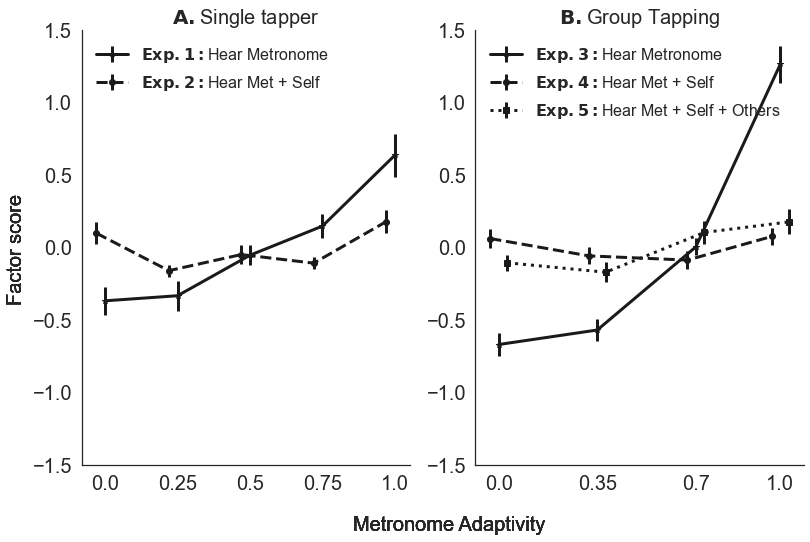

In [257]:
# initalize plot defs
to_zscore = 0 
fig = plt.figure(figsize=(20,8))
expIDs = np.array([1,2,3,4,5])
line_defs = ['k*-', 'ko--', 'k*-', 'ko--', 'ks:']
label_defs = [r"$\bf{" + "Exp. 1: " + "}$" + 'Hear Metronome', r"$\bf{" + "Exp. 2: " + "}$" + 'Hear Met + Self', r"$\bf{" + "Exp. 3: " + "}$" + 'Hear Metronome', r"$\bf{" + "Exp. 4: " + "}$" + 'Hear Met + Self', r"$\bf{" + "Exp. 5: " + "}$" + 'Hear Met + Self + Others']
alpha_offset_defs = [0, -.03, 0, -.03, .03]
fsize = 20
sns.set_style("white")


# loop through each exp
for idx, val in enumerate(expIDs):
    
    # Mask data by experiment
    col = 'factorScore'
    if val < 3: # single tapper
        df = op.loc[op['expID'] == val]
        group = 0
    else: # group tapping
        df = fp.loc[fp['expID'] == val]
        group = 1

    # Create plot   
    if val == 1:
        ax = fig.add_subplot(1, 3, 1)
        plt.title('Single tapper', fontsize = fsize)
        plt.title(r"$\bf{" + "A. " + "}$" + 'Single tapper', fontsize = fsize)
    if val == 3:
        ax = fig.add_subplot(1, 3, 2)
        plt.title(r"$\bf{" + "B. " + "}$" + 'Group Tapping', fontsize = fsize)
        
    data = return_mean_sem(df, group, col, to_zscore)
    print(data, '\n')
    ax.errorbar(data.index.values+alpha_offset_defs[idx], data['mean'], yerr = data['sem'], fmt=line_defs[idx], label=label_defs[idx])  
    ax.set_xticks(data.index.values)
    ax.set_xticklabels(data.index.values, fontsize = fsize)
    ax.set_ylim(-1.5, 1.5) 
    ax.tick_params(axis='both', which='major', labelsize=fsize)
    ax.legend(fontsize = 16, frameon=False, loc = 'upper left')
    #ax.grid(True)
    fig.text(0.38, 0.02, 'Metronome Adaptivity', ha='center', va='center', fontsize=fsize)
    fig.text(0.08, 0.5, 'Factor score', ha='center', va='center', rotation='vertical', fontsize=fsize)

sns.despine()    
sns.set(style="ticks", rc={"lines.linewidth": 3})
plt.savefig('Figures/allExp_factorScores.eps', dpi=300, bbox_inches = 'tight',
    pad_inches = 0.5)

### Run ANOVA on composite rating
As we can see from the tables above, all ratings are highly correlated with one another. 
Therefore, it makes sense to pool these ratings into one composite score. This is also more parsimonious than running 
an ANOVA for each of the ratings in each of the experiments (5-6 x 5), then posthoc t-tests for each.. 

In [301]:
# # Add composite score to all data frames
# comp = op['grooveZ'] + op['syncZ'] + op['likeZ'] - op['diffZ'] + op['inflZ']
# op.insert(0, 'comp', comp, False) 
# comp = fp['group_groove'] + fp['group_sync_self'] + fp['group_cont'] - fp['group_diff'] + fp['group_sync_others'] + fp['group_infl']
# fp.insert(0, 'comp', comp, False) 

In [302]:
# # Run ANOVAs and post-hoc t-tests
# expIDs = np.array([1,2,3,4,5])
# for idx, val in enumerate(expIDs):
#     print('\n\nrm ANOVA, exp:', val)
#     if val < 3:
#         df = op.loc[op['expID'] == val]
#         group = 0
#         sub = 'subID'
#     else:
#         df = fp.loc[fp['expID'] == val]
#         group = 1
#         sub = 'group_num'
    
#     print(rmaov_results(df, group, 'comp', 0))


### Plot composite score for each exp

In [300]:
# # initalize plot defs
# to_zscore = 0 
# fig = plt.figure(figsize=(20,8))
# expIDs = np.array([1,2,3,4,5])
# line_defs = ['k*-', 'ko--', 'k*-', 'ko--', 'ks:']
# label_defs = [r"$\bf{" + "Exp. 1: " + "}$" + 'Hear Metronome', r"$\bf{" + "Exp. 2: " + "}$" + 'Hear Met + Self', r"$\bf{" + "Exp. 3: " + "}$" + 'Hear Metronome', r"$\bf{" + "Exp. 4: " + "}$" + 'Hear Met + Self', r"$\bf{" + "Exp. 5: " + "}$" + 'Hear Met + Self + Others']
# alpha_offset_defs = [0, -.03, 0, -.03, .03]
# fsize = 20
# sns.set_style("white")


# # loop through each exp
# for idx, val in enumerate(expIDs):
    
#     # Mask data by experiment
#     col = 'comp'
#     if val < 3: # single tapper
#         df = op.loc[op['expID'] == val]
#         group = 0
#     else: # group tapping
#         df = fp.loc[fp['expID'] == val]
#         group = 1

#     # Create plot   
#     if val == 1:
#         ax = fig.add_subplot(1, 3, 1)
#         plt.title('Single tapper', fontsize = fsize)
#         plt.title(r"$\bf{" + "A. " + "}$" + 'Single tapper', fontsize = fsize)
#     if val == 3:
#         ax = fig.add_subplot(1, 3, 2)
#         plt.title(r"$\bf{" + "B. " + "}$" + 'Group Tapping', fontsize = fsize)
        
#     data = return_mean_sem(df, group, col, to_zscore)
#     print(data, '\n')
#     ax.errorbar(data.index.values+alpha_offset_defs[idx], data['mean'], yerr = data['sem'], fmt=line_defs[idx], label=label_defs[idx])  
#     ax.set_xticks(data.index.values)
#     ax.set_xticklabels(data.index.values, fontsize = fsize)
#     ax.set_ylim(-4, 4) 
#     ax.tick_params(axis='both', which='major', labelsize=fsize)
#     ax.legend(fontsize = 16, frameon=False, loc = 'upper left')
#     #ax.grid(True)
#     fig.text(0.38, 0.02, 'Metronome Adaptivity', ha='center', va='center', fontsize=fsize)
#     fig.text(0.08, 0.5, 'Composite rating (z-score)', ha='center', va='center', rotation='vertical', fontsize=fsize)

# sns.despine()    
# sns.set(style="ticks", rc={"lines.linewidth": 3})
# plt.savefig('Figures/allExp_composite_rating.eps', dpi=300, bbox_inches = 'tight',
#     pad_inches = 0.5)

# Personality Factors 

Recall that we collected data from all participants on the following scales:
- Musical Sophistication (Gold-MSI)
- Internality, Powerful Others, and Chance (IPC scales)
- Brief form of the Affective Neuroscience Personality scales (BANPS)
 

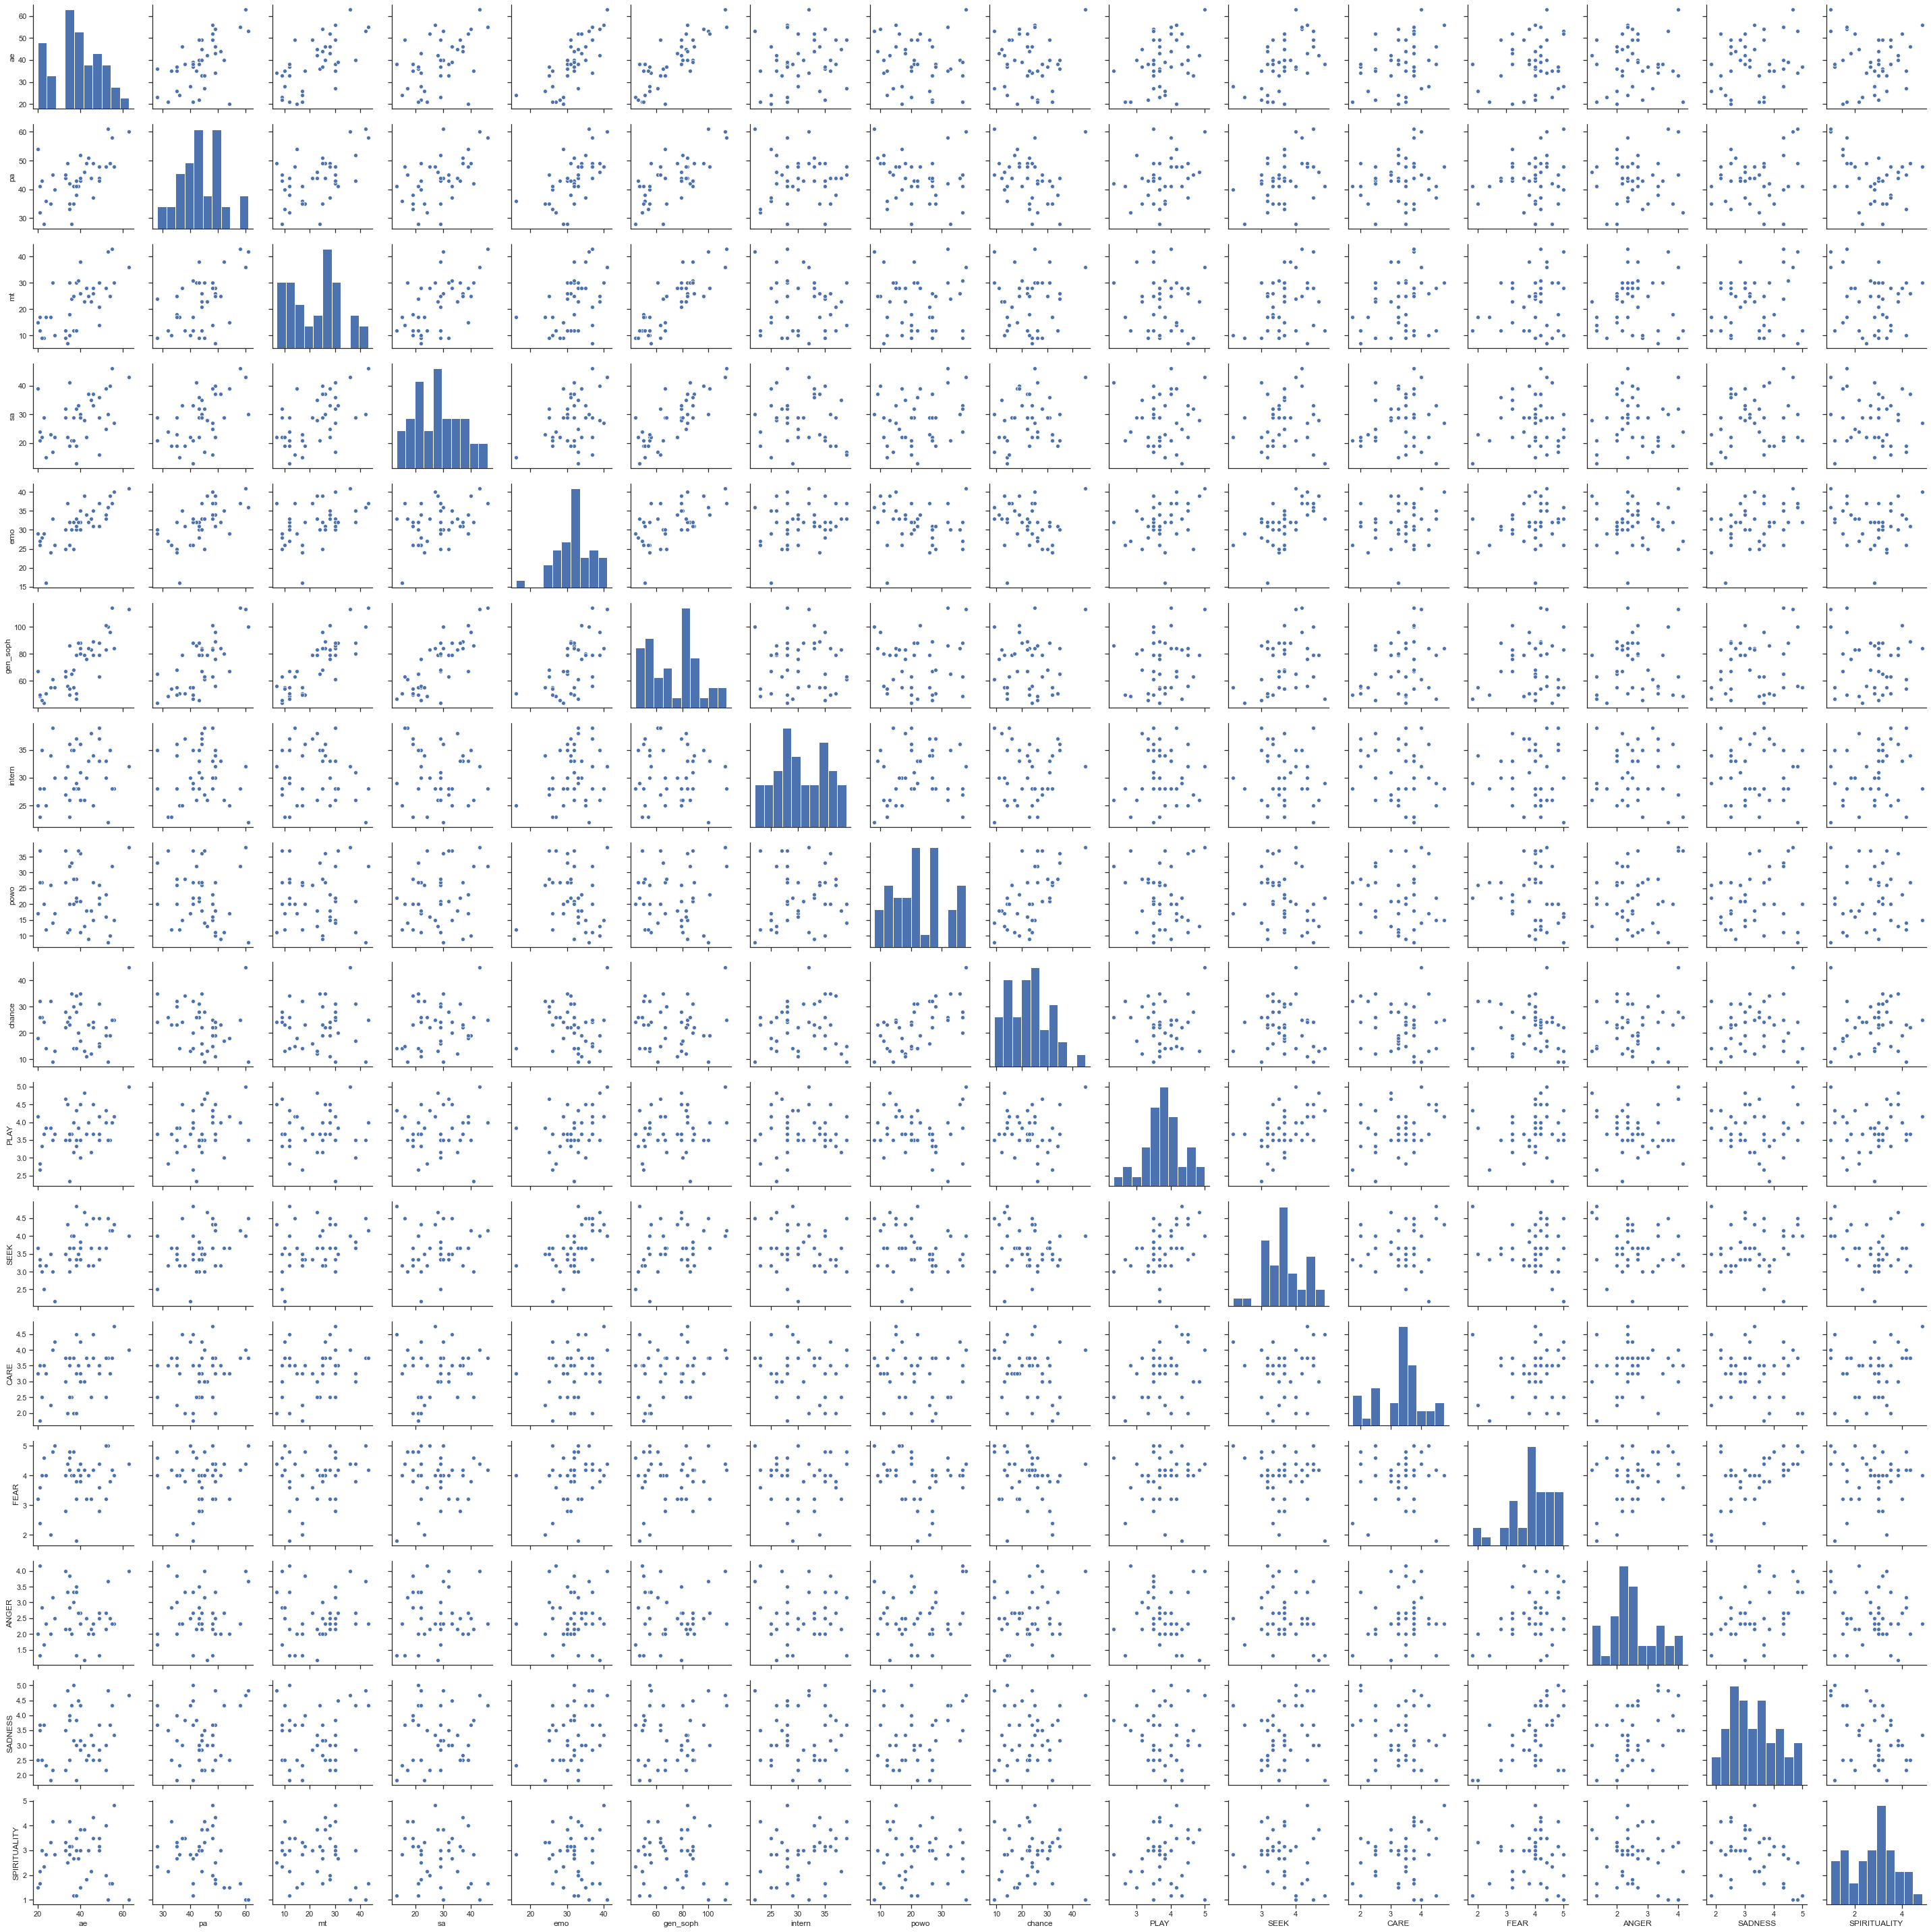

In [282]:
# First let's check correlations among our scales because we don't want to build models with co-linear predictors
df = op
means = df.groupby(['expID', 'subID', 'alpha'], as_index=False).mean() 
a0 = means[means['alpha'] == 0] 
predictors = a0[['ae','pa','mt','sa','emo','gen_soph','intern','powo','chance','PLAY','SEEK','CARE','FEAR','ANGER','SADNESS','SPIRITUALITY']].copy()
sns.pairplot(predictors)

In [283]:
predictors.rcorr(method='pearson', padjust='fdr_bh')

,ae,pa,mt,sa,emo,gen_soph,intern,powo,chance,PLAY,SEEK,CARE,FEAR,ANGER,SADNESS,SPIRITUALITY
ae,-,***,***,*,***,***,,,,,**,,,,,
pa,0.58,-,**,**,***,***,,,,,,,,,,
mt,0.631,0.523,-,**,*,***,,,,,,,,,,
sa,0.469,0.504,0.54,-,,***,,,,,,,,,,
emo,0.746,0.596,0.46,0.352,-,***,,,,,***,,,,,
gen_soph,0.813,0.689,0.842,0.8,0.592,-,,,,,,,,,,
intern,0.169,-0.012,-0.108,-0.136,0.217,-0.03,-,,,,,,,,,
powo,-0.083,-0.188,-0.026,0.208,-0.169,0.057,0.105,-,***,,,,,,,
chance,0.028,-0.184,0.054,0.238,-0.112,0.09,0.058,0.607,-,,,,,,,
PLAY,0.36,0.306,-0.041,0.062,0.316,0.195,0.041,-0.057,0.039,-,*,,,,,


Gold-MSI
- Because many of the subscales of the Gold-MSI are highly correlated, let's just move forward using only the general sophistication score. This makes sense as musical training, perceptual abilities, and singing abilities might all be relevant for tapping accuracy. So keeping general sophistication covers all bases. 

IPC scales
- Because chance and powerful others are highly correlated, let's sum these into one score, which we can think of as external forces driving events in one's life (as opposed to internality)

BANPS
- We have a significant correlation between fear and sadness and between play and seek. This is not so surprising giving that these correlated items fall into the same general affective category (negative and positive, respectively)
- Let's keep seek because we had an a priori hypothesis about it
- Let's keep fear because we know that the care system mediates some sadness behaviors so likely fear is more independent of the other remaining systems

In [284]:
# Add new IPC ratio column to data frames
op.insert(0, 'PC',  op['powo'].to_numpy() + op['chance'].to_numpy())
fp.insert(0, 'PC',  fp['powo'].to_numpy() + fp['chance'].to_numpy())
fp.insert(0, 'std_PC',  (fp['std_powo'].to_numpy() + fp['std_chance'].to_numpy()) / 2)

In [285]:
# Double check that we no longer have correlated predictors 
df = op
means = df.groupby(['expID', 'subID', 'alpha'], as_index=False).mean() 
a0 = means[means['alpha'] == 0] 
predictors = a0[['gen_soph', 'PC', 'intern', 'PLAY', 'SEEK', 'CARE', 'FEAR', 'ANGER', 'SPIRITUALITY']].copy()
predictors.rcorr(method='pearson', padjust='fdr_bh')

,gen_soph,PC,intern,PLAY,SEEK,CARE,FEAR,ANGER,SPIRITUALITY
gen_soph,-,,,,,,,,
PC,0.081,-,,,,,,,
intern,-0.03,0.091,-,,,,,,
PLAY,0.195,-0.012,0.041,-,,,,,
SEEK,0.323,-0.205,-0.116,0.456,-,,,,
CARE,0.29,-0.133,-0.21,0.292,0.129,-,,,
FEAR,0.13,-0.197,-0.031,0.109,-0.154,0.075,-,,
ANGER,0.031,0.21,-0.052,-0.044,-0.143,0.006,0.324,-,
SPIRITUALITY,-0.089,0.073,0.234,0.091,-0.209,0.203,0.058,-0.11,-


In [286]:
# Looks good, although seek and play still have fairly high correlation. Could consider removing one of those
# Fear and anger also have a high correlation. Let's only keep one from each of these categories
predictors = a0[['gen_soph', 'PC', 'intern', 'SEEK', 'CARE', 'FEAR', 'SPIRITUALITY']].copy()
predictors.rcorr(method='pearson', padjust='fdr_bh')

,gen_soph,PC,intern,SEEK,CARE,FEAR,SPIRITUALITY
gen_soph,-,,,,,,
PC,0.081,-,,,,,
intern,-0.03,0.091,-,,,,
SEEK,0.323,-0.205,-0.116,-,,,
CARE,0.29,-0.133,-0.21,0.129,-,,
FEAR,0.13,-0.197,-0.031,-0.154,0.075,-,
SPIRITUALITY,-0.089,0.073,0.234,-0.209,0.203,0.058,-


In [287]:
# Now let's scale all variables for better model building
a0 = a0 - a0.mean()
a0_individ = a0;

# Do same for group data
df = fp
means = df.groupby(['expID', 'group', 'alpha'], as_index=False).mean() 
a0_group = means[means['alpha'] == 0] 
a0_group = a0_group.drop(['group'], axis=1) # don't need string of group label
a0_group = a0_group - a0_group.mean()

### Relationship between scales and tapping performance when alpha = 0

In [288]:
md = smf.ols("std_async ~ gen_soph + PC + intern + SEEK + CARE + FEAR + SPIRITUALITY", a0_individ)
mdf = md.fit()
print('Individual Data\n')
print(mdf.summary())

Individual Data

                            OLS Regression Results                            
Dep. Variable:              std_async   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     1.978
Date:                Sun, 30 Aug 2020   Prob (F-statistic):             0.0883
Time:                        20:39:33   Log-Likelihood:                -154.41
No. Observations:                  41   AIC:                             324.8
Df Residuals:                      33   BIC:                             338.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -3.053e-15      1.

In [289]:
# For group data it might make sense to look at both the average value on some scale, as well as the standard deviation.
# For instance the variability among group memebers' musical ability might matter more than their avg level
predictors = a0_group[['gen_soph','PC', 'intern', 'SEEK', 'CARE', 'FEAR', 'SPIRITUALITY', 'std_gen_soph',
                       'std_PC', 'std_intern', 'std_SEEK', 'std_CARE', 'std_FEAR', 'std_SPIRITUALITY']].copy()
predictors.rcorr(method='pearson', padjust='fdr_bh')

,gen_soph,PC,intern,SEEK,CARE,FEAR,SPIRITUALITY,std_gen_soph,std_PC,std_intern,std_SEEK,std_CARE,std_FEAR,std_SPIRITUALITY
gen_soph,-,,,,,,,,,,,,,
PC,0.201,-,,,,,,,,,,,,
intern,-0.007,-0.22,-,,,,,,,,,,,
SEEK,0.206,-0.199,0.208,-,,,,,,,,,,
CARE,-0.054,-0.045,-0.052,-0.02,-,,,,,,,,,
FEAR,0.057,0.111,-0.277,0.084,-0.055,-,,,,,,,,
SPIRITUALITY,0.168,0.088,-0.107,-0.091,0.146,-0.14,-,,,,,,,
std_gen_soph,0.224,0.203,0.042,0.097,-0.218,0.1,0.009,-,,,,,,
std_PC,0.169,0.043,0.156,-0.06,0.046,0.083,-0.116,0.032,-,,,,,
std_intern,-0.088,0.13,-0.232,-0.205,0.004,0.171,0.082,0.158,0.14,-,,,,


In [290]:
# Std is not so correlated with mean so let's build one large model
md = smf.ols("sd_avg_async ~ gen_soph + std_gen_soph + PC + std_PC + intern + std_intern + SEEK + std_SEEK + CARE + std_CARE + FEAR + std_FEAR + SPIRITUALITY + std_SPIRITUALITY", a0_group)
mdf = md.fit()
print('\n\nGroup Data\n')
print(mdf.summary())



Group Data

                            OLS Regression Results                            
Dep. Variable:           sd_avg_async   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     1.640
Date:                Sun, 30 Aug 2020   Prob (F-statistic):             0.0967
Time:                        20:39:48   Log-Likelihood:                -262.81
No. Observations:                  71   AIC:                             555.6
Df Residuals:                      56   BIC:                             589.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.021e-1

### Relationship between scales and ratings when alpha = 0

In [291]:
md = smf.ols("factorScore ~ gen_soph + PC + intern + SEEK + CARE + FEAR + SPIRITUALITY", a0_individ)
mdf = md.fit()
print('Individual Data\n')
print(mdf.summary())

Individual Data

                            OLS Regression Results                            
Dep. Variable:            factorScore   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                 -0.106
Method:                 Least Squares   F-statistic:                    0.4503
Date:                Sun, 30 Aug 2020   Prob (F-statistic):              0.863
Time:                        20:40:09   Log-Likelihood:                -22.237
No. Observations:                  41   AIC:                             60.47
Df Residuals:                      33   BIC:                             74.18
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept             0      0.

In [292]:
md = smf.ols("factorScore ~ gen_soph + std_gen_soph + PC + std_PC + intern + std_intern + SEEK + std_SEEK + CARE + std_CARE + FEAR + std_FEAR + SPIRITUALITY + std_SPIRITUALITY", a0_group)
mdf = md.fit()
print('\n\nGroup Data\n')
print(mdf.summary())



Group Data

                            OLS Regression Results                            
Dep. Variable:            factorScore   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                 -0.113
Method:                 Least Squares   F-statistic:                    0.4936
Date:                Sun, 30 Aug 2020   Prob (F-statistic):              0.927
Time:                        20:41:24   Log-Likelihood:                -42.149
No. Observations:                  71   AIC:                             114.3
Df Residuals:                      56   BIC:                             148.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         7.459e-1

### Relationship between scales and alpha benefit - Tapping performance

In [293]:
# Prepare single and group data tables
df = op
means = df.groupby(['expID', 'subID', 'alpha'], as_index=False).mean() 
a25 = means[means['alpha'] == .25] 
a25.insert(0, "opt_benefit", a0_individ['std_async'].to_numpy() - a25['std_async'].to_numpy(), True)
a25 = a25 - a25.mean()

df = fp
means = df.groupby(['expID', 'group', 'alpha'], as_index=False).mean() 
a35 = means[means['alpha'] == .35] 
a35.insert(0, "opt_benefit", a0_group['sd_avg_async'].to_numpy() - a35['sd_avg_async'].to_numpy(), True)
a35 = a35.drop(['group'], axis=1) # don't need string of group label
a35 = a35 - a35.mean()

In [294]:
md = smf.ols("opt_benefit ~ gen_soph + PC + intern + SEEK + CARE + FEAR + SPIRITUALITY", a25)
mdf = md.fit()
print('Individual Data\n')
print(mdf.summary())

Individual Data

                            OLS Regression Results                            
Dep. Variable:            opt_benefit   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     2.448
Date:                Sun, 30 Aug 2020   Prob (F-statistic):             0.0388
Time:                        20:42:17   Log-Likelihood:                -131.87
No. Observations:                  41   AIC:                             279.7
Df Residuals:                      33   BIC:                             293.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.609e-15      1.

In [295]:
md = smf.ols("opt_benefit ~ gen_soph + std_gen_soph + PC + std_PC + intern + std_intern + SEEK + std_SEEK + CARE + std_CARE + FEAR + std_FEAR + SPIRITUALITY + std_SPIRITUALITY", a35)
mdf = md.fit()
print('\n\nGroup Data\n')
print(mdf.summary())



Group Data

                            OLS Regression Results                            
Dep. Variable:            opt_benefit   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1.234
Date:                Sun, 30 Aug 2020   Prob (F-statistic):              0.278
Time:                        20:42:20   Log-Likelihood:                -246.99
No. Observations:                  71   AIC:                             524.0
Df Residuals:                      56   BIC:                             557.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -8.549e-1

### Relationship between scales and alpha benefit - Subjective ratings

In [298]:
# Prepare single and group data tables
df = op
means = df.groupby(['expID', 'subID', 'alpha'], as_index=False).mean() 
a25 = means[means['alpha'] == .25] 
a25.insert(0, "opt_benefit", a0_individ['factorScore'].to_numpy() - a25['factorScore'].to_numpy(), True)
a25 = a25 - a25.mean()

df = fp
means = df.groupby(['expID', 'group', 'alpha'], as_index=False).mean() 
a35 = means[means['alpha'] == .35] 
a35.insert(0, "opt_benefit", a0_group['factorScore'].to_numpy() - a35['factorScore'].to_numpy(), True)
a35 = a35.drop(['group'], axis=1) # don't need string of group label
a35 = a35 - a35.mean()

md = smf.ols("opt_benefit ~ gen_soph + PC + intern + SEEK + CARE + FEAR + SPIRITUALITY", a25)
mdf = md.fit()
print('Individual Data\n')
print(mdf.summary())

Individual Data

                            OLS Regression Results                            
Dep. Variable:            opt_benefit   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     1.452
Date:                Sun, 30 Aug 2020   Prob (F-statistic):              0.218
Time:                        21:31:22   Log-Likelihood:                -19.218
No. Observations:                  41   AIC:                             54.44
Df Residuals:                      33   BIC:                             68.14
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.939e-18      0.

In [299]:
md = smf.ols("opt_benefit ~ gen_soph + std_gen_soph + PC + std_PC + intern + std_intern + SEEK + std_SEEK + CARE + std_CARE + FEAR + std_FEAR + SPIRITUALITY + std_SPIRITUALITY", a35)
mdf = md.fit()
print('\n\nGroup Data\n')
print(mdf.summary())



Group Data

                            OLS Regression Results                            
Dep. Variable:            opt_benefit   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                 -0.060
Method:                 Least Squares   F-statistic:                    0.7184
Date:                Sun, 30 Aug 2020   Prob (F-statistic):              0.747
Time:                        21:34:45   Log-Likelihood:                -43.073
No. Observations:                  71   AIC:                             116.1
Df Residuals:                      56   BIC:                             150.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -5.204e-1

### Is musicianship a factor in how much people benefit from adaptivity? 
We have the promising finding that GOLD-MSI General Sophistication is only mildly predictive in the baseline condition in single person tapping experiments. This leaves open the possibility that people of all musical levels can benefit from metronome adaptivity. To test this explicitly, let's median split our participants by musicianship and run some t-tests.

Overall distribution of general sophistication scores:

count    1731.000000
mean       72.714038
std        18.296553
min        44.000000
25%        55.000000
50%        76.000000
75%        86.000000
max       114.000000
Name: gen_soph, dtype: float64

Median: 76.0


Low musicianship group:

 count    869.000000
mean      56.891830
std        8.404782
min       44.000000
25%       50.000000
50%       55.000000
75%       65.000000
max       76.000000
Name: gen_soph, dtype: float64


High musicianship group:

 count    862.000000
mean      88.664733
std        9.697163
min       79.000000
25%       83.000000
50%       86.000000
75%       89.000000
max      114.000000
Name: gen_soph, dtype: float64


T-test comparing adaptivity benefit in low vs. high musicians:

            T    dof       tail     p-val          CI95%  cohen-d   BF10  \
T-test  0.397  24.14  two-sided  0.694829  [-4.38, 6.46]    0.133  0.339   

        power  
T-test  0.068  


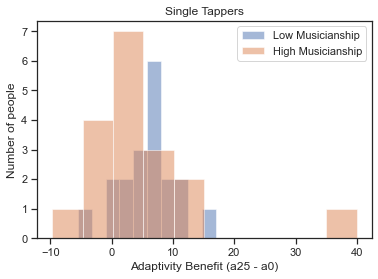



T-test comparing adaptivity benefit in low musicians to zero:

            T  dof     tail     p-val       CI95%  cohen-d      BF10  power
T-test  5.334   18  greater  0.000023  [4.0, inf]    1.224  1133.747    1.0
mean benefit =  5.927601934375411


T-test comparing adaptivity benefit in high musicians to zero:

            T  dof     tail     p-val        CI95%  cohen-d   BF10  power
T-test  2.053   17  greater  0.027875  [0.75, inf]    0.484  2.651  0.628
mean benefit =  4.885059845849574


In [200]:
print('Overall distribution of general sophistication scores:\n')
print(op['gen_soph'].describe())
print('\nMedian:', op['gen_soph'].median())

# do median split
lowMus = op[op['gen_soph'] <= op['gen_soph'].median()]
highMus = op[op['gen_soph'] > op['gen_soph'].median()]

# get adaptivity benefit
meansLow = lowMus.groupby(['subID', 'alpha'], as_index=False).mean() 
a25Low = meansLow[meansLow['alpha'] == .25] 
a0Low = meansLow[meansLow['alpha'] == 0] 
optBenLow = a0Low['std_async'].to_numpy() - a25Low['std_async'].to_numpy()

meansHigh = highMus.groupby(['subID', 'alpha'], as_index=False).mean() 
a25High = meansHigh[meansHigh['alpha'] == .25] 
a0High = meansHigh[meansHigh['alpha'] == 0] 
optBenHigh = a0High['std_async'].to_numpy() - a25High['std_async'].to_numpy()

# print results
print('\n\nLow musicianship group:\n\n', lowMus['gen_soph'].describe())
print('\n\nHigh musicianship group:\n\n', highMus['gen_soph'].describe())

print('\n\nT-test comparing adaptivity benefit in low vs. high musicians:\n')
print(pg.ttest(optBenLow, optBenHigh, tail = 'two-sided', correction='auto'))

# plot
plt.hist(optBenLow, alpha=0.5, label='Low Musicianship')
plt.hist(optBenHigh, alpha=0.5, label='High Musicianship')
plt.legend(loc='upper right')
plt.title('Single Tappers')
plt.xlabel('Adaptivity Benefit (a25 - a0)')
plt.ylabel('Number of people')
plt.show()




# print results
print('\n\nT-test comparing adaptivity benefit in low musicians to zero:\n')
print(pg.ttest(optBenLow, 0, tail = 'one-sided', correction='auto'))
print('mean benefit = ', optBenLow.mean())

print('\n\nT-test comparing adaptivity benefit in high musicians to zero:\n')
print(pg.ttest(optBenHigh, 0, tail = 'one-sided', correction='auto'))
print('mean benefit = ', optBenHigh.mean())

#### Now do the same for group tappers
NOTE: this will be on average group ability. 

Overall distribution of general sophistication scores:

count    1628.000000
mean       70.638360
std         7.457986
min        54.000000
25%        67.750000
50%        70.500000
75%        74.000000
max        94.250000
Name: gen_soph, dtype: float64

Median: 70.5


Low musicianship group:

 count    879.000000
mean      65.584755
std        4.769658
min       54.000000
25%       62.000000
50%       68.000000
75%       69.500000
max       70.500000
Name: gen_soph, dtype: float64


High musicianship group:

 count    749.000000
mean      76.569092
std        5.389676
min       70.750000
25%       72.000000
50%       74.250000
75%       79.750000
max       94.250000
Name: gen_soph, dtype: float64


T-test comparing adaptivity benefit in low vs. high musicians:

            T    dof       tail     p-val          CI95%  cohen-d   BF10  \
T-test -1.501  44.82  two-sided  0.140364  [-7.93, 1.16]    0.379  0.641   

        power  
T-test  0.347  


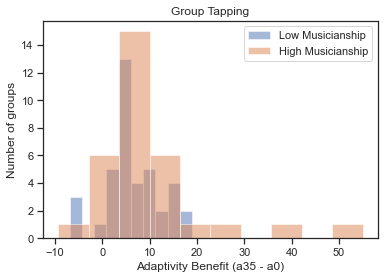



T-test comparing adaptivity benefit in low musicians to zero:

            T  dof     tail         p-val        CI95%  cohen-d       BF10  \
T-test  6.677   38  greater  3.377723e-08  [4.85, inf]    1.069  4.258e+05   

        power  
T-test    1.0  
mean benefit =  6.487495072414531


T-test comparing adaptivity benefit in high musicians to zero:

            T  dof     tail     p-val        CI95%  cohen-d      BF10  power
T-test  4.848   31  greater  0.000017  [6.42, inf]    0.857  1395.652  0.999
mean benefit =  9.87483033484896


In [201]:
print('Overall distribution of general sophistication scores:\n')
print(fp['gen_soph'].describe())
print('\nMedian:', fp['gen_soph'].median())

lowMus = fp[fp['gen_soph'] <= fp['gen_soph'].median()]
highMus = fp[fp['gen_soph'] > fp['gen_soph'].median()]

meansLow = lowMus.groupby(['group', 'alpha'], as_index=False).mean() 
a25Low = meansLow[meansLow['alpha'] == .35] 
a0Low = meansLow[meansLow['alpha'] == 0] 
optBenLow = a0Low['sd_avg_async'].to_numpy() - a25Low['sd_avg_async'].to_numpy()

meansHigh = highMus.groupby(['group', 'alpha'], as_index=False).mean() 
a25High = meansHigh[meansHigh['alpha'] == .35] 
a0High = meansHigh[meansHigh['alpha'] == 0] 
optBenHigh = a0High['sd_avg_async'].to_numpy() - a25High['sd_avg_async'].to_numpy()

print('\n\nLow musicianship group:\n\n', lowMus['gen_soph'].describe())
print('\n\nHigh musicianship group:\n\n', highMus['gen_soph'].describe())

print('\n\nT-test comparing adaptivity benefit in low vs. high musicians:\n')
print(pg.ttest(optBenLow, optBenHigh, tail = 'two-sided', correction='auto'))

plt.hist(optBenLow, alpha=0.5, label='Low Musicianship')
plt.hist(optBenHigh, alpha=0.5, label='High Musicianship')
plt.legend(loc='upper right')
plt.title('Group Tapping')
plt.xlabel('Adaptivity Benefit (a35 - a0)')
plt.ylabel('Number of groups')
plt.show()


print('\n\nT-test comparing adaptivity benefit in low musicians to zero:\n')
print(pg.ttest(optBenLow, 0, tail = 'one-sided', correction='auto'))
print('mean benefit = ', optBenLow.mean())

print('\n\nT-test comparing adaptivity benefit in high musicians to zero:\n')
print(pg.ttest(optBenHigh, 0, tail = 'one-sided', correction='auto'))
print('mean benefit = ', optBenHigh.mean())